**Medical Product Delivery: Building a Data-Driven Dashboard for Optimizing Medical Product Delivery Across Poor Road Networks in Nigeria **

** Environment Setup and Data Loading**

In [1]:
# Install required libraries
!pip install geopandas shapely pandas numpy fiona pyproj folium scikit-learn

# Import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


**DELIVERABLES ONE: Data Collection & Cleaning**

In [2]:
import chardet

with open(r"C:\Users\hp\Desktop\doub_PDF\HealthFacility.csv", 'rb') as f:
    result = chardet.detect(f.read(100000))
print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [3]:
import chardet
import pandas as pd

def detect_encoding(path, n_bytes=100000):
    with open(path, "rb") as f:
        raw = f.read(n_bytes)
    result = chardet.detect(raw)
    return result  # dict with 'encoding', 'confidence', 'language' (maybe None)

def robust_read_csv(path, tries=None, n_bytes=100000):
    # detect first
    detected = detect_encoding(path, n_bytes=n_bytes)
    print(f"Chardet guess for {path}: {detected}")

    # build priority list of encodings to try
    encodings_to_try = []
    if detected.get("encoding"):
        encodings_to_try.append(detected["encoding"])
    # common fallbacks
    encodings_to_try += ["utf-8", "cp1252", "latin1"]  # cp1252 ~ windows-1252; latin1 is very permissive

    # remove duplicates while preserving order
    seen = set()
    encodings = [e for e in encodings_to_try if not (e in seen or seen.add(e))]

    last_exc = None
    for enc in encodings:
        try:
            print(f"Trying encoding: {enc}")
            df = pd.read_csv(path, encoding=enc)
            print(f"Success reading {path} with encoding: {enc}")
            return df, enc
        except Exception as e:
            print(f"Failed with {enc}: {type(e).__name__}: {e}")
            last_exc = e

    
    try:
        print("Final fallback: reading with encoding='utf-8' and encoding_errors='replace'")
        df = pd.read_csv(path, encoding='utf-8', encoding_errors='replace')
        print("Success with encoding_errors='replace' (some characters replaced).")
        return df, "utf-8 (with replace)"
    except Exception as e:
        print("Fallback with encoding_errors also failed.")
        raise last_exc or e

# Paths
hf_path = r"C:\Users\hp\Desktop\doub_PDF\HealthFacility.csv"
road_path = r"C:\Users\hp\Desktop\doub_PDF\ROAD.csv"

# Read HealthFacility 
health_facility, health_enc = robust_read_csv(hf_path)
road_data, road_enc = robust_read_csv(road_path)

print("\n--- Summary ---")
print("HealthFacility encoding used:", health_enc, "shape:", health_facility.shape)
print("ROAD encoding used:", road_enc, "shape:", road_data.shape)

# Show a bit of the data
print("\nHealthFacility columns:", health_facility.columns.tolist())
print("\nROAD columns:", road_data.columns.tolist())

print("\nHealthFacility sample:")
print(health_facility.head())
print("\nROAD sample:")
print(road_data.head())


Chardet guess for C:\Users\hp\Desktop\doub_PDF\HealthFacility.csv: {'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}
Trying encoding: ISO-8859-1
Success reading C:\Users\hp\Desktop\doub_PDF\HealthFacility.csv with encoding: ISO-8859-1
Chardet guess for C:\Users\hp\Desktop\doub_PDF\ROAD.csv: {'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
Trying encoding: ascii
Failed with ascii: UnicodeDecodeError: 'ascii' codec can't decode byte 0x92 in position 2503: ordinal not in range(128)
Trying encoding: utf-8
Failed with utf-8: UnicodeDecodeError: 'utf-8' codec can't decode byte 0x92 in position 10: invalid start byte
Trying encoding: cp1252
Success reading C:\Users\hp\Desktop\doub_PDF\ROAD.csv with encoding: cp1252

--- Summary ---
HealthFacility encoding used: ISO-8859-1 shape: (4548, 23)
ROAD encoding used: cp1252 shape: (1048575, 15)

HealthFacility columns: ['OBJECTID', 'globalid', 'nhfr_uid', 'nhfr_facility_code', 'country', 'iso', 'state', 'lga', 'lga_name_disagreem

In [4]:
# Load shapefile for roads (lines)
road_shapefile = gpd.read_file(r"C:\Users\hp\Desktop\doub_PDF\Shape\hotosm_nga_roads_lines_shp")

print("Road Shapefile Shape:", road_shapefile.shape)
print("\nRoad Shapefile Columns:")
print(road_shapefile.columns.tolist())
print("\nRoad Shapefile Sample:")
print(road_shapefile.head())
print("\nRoad Shapefile CRS:", road_shapefile.crs)

Road Shapefile Shape: (1631160, 14)

Road Shapefile Columns:
['name', 'name_en', 'highway', 'surface', 'smoothness', 'width', 'lanes', 'oneway', 'bridge', 'layer', 'source', 'osm_id', 'osm_type', 'geometry']

Road Shapefile Sample:
   name name_en       highway  surface smoothness width lanes oneway bridge  \
0  None    None   residential     None       None  None  None   None   None   
1  None    None  unclassified     None       None  None  None   None   None   
2  None    None         track     None       None  None  None   None   None   
3  None    None   residential     None       None  None  None   None   None   
4  None    None  unclassified  unpaved       None  None  None   None   None   

  layer source     osm_id   osm_type  \
0  None   None  502971812  ways_line   
1  None   None  502971827  ways_line   
2  None   None  502971818  ways_line   
3  None   None  502971819  ways_line   
4  None   None  502971821  ways_line   

                                            geometry

In [5]:
# Load GeoJSON for flood zones
flood_zones = gpd.read_file(r"C:\Users\hp\Downloads\nga_adminpoints.geojson")

print("Flood Zones Shape:", flood_zones.shape)
print("\nFlood Zones Columns:")
print(flood_zones.columns.tolist())
print("\nFlood Zones Sample:")
print(flood_zones.head())
print("\nFlood Zones CRS:", flood_zones.crs)

Flood Zones Shape: (1526, 40)

Flood Zones Columns:
['admin_level', 'name', 'name1', 'name2', 'name3', 'x_coord', 'y_coord', 'adm4_name', 'adm4_name1', 'adm4_name2', 'adm4_name3', 'adm4_pcode', 'adm3_name', 'adm3_name1', 'adm3_name2', 'adm3_name3', 'adm3_pcode', 'adm2_name', 'adm2_name1', 'adm2_name2', 'adm2_name3', 'adm2_pcode', 'adm1_name', 'adm1_name1', 'adm1_name2', 'adm1_name3', 'adm1_pcode', 'adm0_name', 'adm0_name1', 'adm0_name2', 'adm0_name3', 'adm0_pcode', 'valid_on', 'valid_to', 'version', 'lang', 'lang1', 'lang2', 'lang3', 'geometry']

Flood Zones Sample:
   admin_level       name name1 name2 name3    x_coord   y_coord adm4_name  \
0            0    Nigeria  None  None  None   7.960072  9.082537      None   
1            1       Abia  None  None  None   7.488342  5.431820      None   
2            1    Adamawa  None  None  None  12.291562  9.162647      None   
3            1  Akwa Ibom  None  None  None   7.795569  4.990470      None   
4            1    Anambra  None  None

**Data Preparation and Column Mapping**

In [6]:
# Identify and map columns from health facility data

def identify_columns(df, target_cols):
    """Identify which columns match our target columns"""
    mapping = {}
    df_cols = df.columns.tolist()
    
    for target in target_cols:
        for col in df_cols:
            if target.lower() in col.lower():
                mapping[col] = target
                break
    
    return mapping

target_columns = ['State', 'LGA', 'Facility_Name', 'Latitude', 'Longitude']

# Map health facility columns
health_mapping = identify_columns(health_facility, target_columns)
print("Health Facility Column Mapping:")
print(health_mapping)

# Rename columns
health_facility_clean = health_facility.copy()
if health_mapping:
    health_facility_clean.rename(columns=health_mapping, inplace=True)

print("\nCleaned Health Facility Columns:")
print(health_facility_clean.columns.tolist())

Health Facility Column Mapping:
{'state': 'State', 'lga': 'LGA', 'facility_name': 'Facility_Name', 'latitude': 'Latitude', 'longitude': 'Longitude'}

Cleaned Health Facility Columns:
['OBJECTID', 'globalid', 'nhfr_uid', 'nhfr_facility_code', 'country', 'iso', 'State', 'LGA', 'lga_name_disagreement', 'ward', 'ward_name_disagreement', 'Facility_Name', 'facility_name_source', 'ownership', 'ownership_type', 'facility_level', 'facility_level_option', 'Latitude', 'Longitude', 'geocoordinates_source', 'last_updated', 'x', 'y']


In [7]:
# Check for required columns and create if missing
required_cols = ['State', 'LGA', 'Facility_Name', 'Latitude', 'Longitude']

for col in required_cols:
    if col not in health_facility_clean.columns:
        print(f"Warning: {col} not found in data")
        
        # Attempt to create missing columns from available data
        if col == 'Facility_Name' and 'facility' in str(health_facility_clean.columns).lower():
            facility_col = [c for c in health_facility_clean.columns if 'facility' in c.lower()][0]
            health_facility_clean['Facility_Name'] = health_facility_clean[facility_col]
        elif col == 'State' and 'state' in str(health_facility_clean.columns).lower():
            state_col = [c for c in health_facility_clean.columns if 'state' in c.lower()][0]
            health_facility_clean['State'] = health_facility_clean[state_col]
        elif col == 'LGA' and 'lga' in str(health_facility_clean.columns).lower():
            lga_col = [c for c in health_facility_clean.columns if 'lga' in c.lower()][0]
            health_facility_clean['LGA'] = health_facility_clean[lga_col]

# Display cleaned data
print("\nFinal Health Facility Columns:")
print(health_facility_clean.columns.tolist())
print("\nSample of cleaned data:")
print(health_facility_clean.head())


Final Health Facility Columns:
['OBJECTID', 'globalid', 'nhfr_uid', 'nhfr_facility_code', 'country', 'iso', 'State', 'LGA', 'lga_name_disagreement', 'ward', 'ward_name_disagreement', 'Facility_Name', 'facility_name_source', 'ownership', 'ownership_type', 'facility_level', 'facility_level_option', 'Latitude', 'Longitude', 'geocoordinates_source', 'last_updated', 'x', 'y']

Sample of cleaned data:
   OBJECTID                              globalid    nhfr_uid  \
0         1  9c2b58dd-1e99-49b9-970e-eabce1c7dd10  57132712.0   
1         2  5a3864b5-d66b-4683-90cd-9c76af393450  42800186.0   
2         3  cfe845eb-9f71-4b99-9603-d2f389a73ba0  26934297.0   
3         4  0fcbdf4a-8ea2-4df9-9167-4c9f1377f27c  43109689.0   
4         5  12c47bd1-535e-4de7-9cad-ad34f43b1965  28489340.0   

  nhfr_facility_code  country  iso  State         LGA  lga_name_disagreement  \
0   08/07/1/1/1/0030  Nigeria  NGA  Borno      Damboa                      0   
1   08/02/1/1/1/0044  Nigeria  NGA  Borno  Askira

**Create GeoDataFrame and Handle Missing Coordinates**

In [8]:
# Drop rows without coordinates
print(f"Original records: {len(health_facility_clean)}")

# Check for latitude/longitude columns
lat_col = None
lon_col = None

for col in health_facility_clean.columns:
    if 'lat' in col.lower() and lat_col is None:
        lat_col = col
    if 'lon' in col.lower() and lon_col is None:
        lon_col = col

print(f"\nLatitude column: {lat_col}")
print(f"Longitude column: {lon_col}")

# Standardize column names
if lat_col and lat_col != 'Latitude':
    health_facility_clean.rename(columns={lat_col: 'Latitude'}, inplace=True)
if lon_col and lon_col != 'Longitude':
    health_facility_clean.rename(columns={lon_col: 'Longitude'}, inplace=True)

# Remove invalid coordinates
health_facility_clean = health_facility_clean.dropna(subset=['Latitude', 'Longitude'])
health_facility_clean = health_facility_clean[
    (health_facility_clean['Latitude'].between(4, 14)) &  # Nigeria's latitude range
    (health_facility_clean['Longitude'].between(2.5, 15))  # Nigeria's longitude range
]

print(f"Records after coordinate filtering: {len(health_facility_clean)}")

Original records: 4548

Latitude column: Latitude
Longitude column: Longitude
Records after coordinate filtering: 4548


In [9]:
# Convert to GeoDataFrame

geometry = [Point(xy) for xy in zip(health_facility_clean['Longitude'], health_facility_clean['Latitude'])]
health_gdf = gpd.GeoDataFrame(health_facility_clean, geometry=geometry, crs='EPSG:4326')

print("GeoDataFrame created successfully!")
print(f"Total facilities: {len(health_gdf)}")
print(f"\nCRS: {health_gdf.crs}")
print(f"\nSample geometry:")
print(health_gdf.head())

GeoDataFrame created successfully!
Total facilities: 4548

CRS: EPSG:4326

Sample geometry:
   OBJECTID                              globalid    nhfr_uid  \
0         1  9c2b58dd-1e99-49b9-970e-eabce1c7dd10  57132712.0   
1         2  5a3864b5-d66b-4683-90cd-9c76af393450  42800186.0   
2         3  cfe845eb-9f71-4b99-9603-d2f389a73ba0  26934297.0   
3         4  0fcbdf4a-8ea2-4df9-9167-4c9f1377f27c  43109689.0   
4         5  12c47bd1-535e-4de7-9cad-ad34f43b1965  28489340.0   

  nhfr_facility_code  country  iso  State         LGA  lga_name_disagreement  \
0   08/07/1/1/1/0030  Nigeria  NGA  Borno      Damboa                      0   
1   08/02/1/1/1/0044  Nigeria  NGA  Borno  Askira/Uba                      0   
2   08/02/1/1/1/0034  Nigeria  NGA  Borno  Askira/Uba                      0   
3   08/06/1/1/1/0021  Nigeria  NGA  Borno      Chibok                      0   
4   08/06/1/1/1/0025  Nigeria  NGA  Borno      Chibok                      0   

         ward  ...    ownership_type

** Compute Road Quality**

In [10]:
# Ensure CRS matches
if road_shapefile.crs != health_gdf.crs:
    road_shapefile = road_shapefile.to_crs(health_gdf.crs)

# Compute Road Quality based on road attributes
def compute_road_quality(road_gdf):
    """
    Compute road quality score based on available attributes
    Returns: Good, Fair, or Poor
    """
    road_gdf = road_gdf.copy()
    
    # Check for surface or highway type columns
    quality_scores = []
    
    for idx, row in road_gdf.iterrows():
        score = 50  # Default: Fair
        
        # Check highway type if available
        if 'highway' in road_gdf.columns:
            highway_type = str(row['highway']).lower()
            if highway_type in ['motorway', 'trunk', 'primary']:
                score = 80  # Good
            elif highway_type in ['secondary', 'tertiary']:
                score = 60  # Fair
            elif highway_type in ['unclassified', 'track', 'path']:
                score = 30  # Poor
        
        # Check surface type if available
        if 'surface' in road_gdf.columns:
            surface = str(row['surface']).lower()
            if surface in ['asphalt', 'paved', 'concrete']:
                score = min(score + 20, 100)
            elif surface in ['unpaved', 'gravel', 'dirt', 'earth']:
                score = max(score - 20, 0)
        
        # Categorize
        if score >= 65:
            quality = 'Good'
        elif score >= 40:
            quality = 'Fair'
        else:
            quality = 'Poor'
        
        quality_scores.append(quality)
    
    road_gdf['Road_Quality'] = quality_scores
    return road_gdf

# Compute road quality
road_shapefile = compute_road_quality(road_shapefile)

print("Road Quality Distribution:")
print(road_shapefile['Road_Quality'].value_counts())
print("\nSample with Road Quality:")
print(road_shapefile[['highway', 'Road_Quality']].head(10) if 'highway' in road_shapefile.columns else road_shapefile[['Road_Quality']].head(10))

Road Quality Distribution:
Road_Quality
Fair    947660
Poor    654307
Good     29193
Name: count, dtype: int64

Sample with Road Quality:
        highway Road_Quality
0   residential         Fair
1  unclassified         Poor
2         track         Poor
3   residential         Fair
4  unclassified         Poor
5         track         Poor
6  unclassified         Poor
7  unclassified         Poor
8         track         Poor
9         track         Poor


**Compute Distance(Km) to Nearest Road**

In [11]:
import geopandas as gpd
import pandas as pd


#  Convert to GeoDataFrame
health_gdf = gpd.GeoDataFrame(
    health_facility,
    geometry=gpd.points_from_xy(health_facility['longitude'], health_facility['latitude']),
    crs="EPSG:4326"
)

#  Project to a coordinate system in meters (Nigeria: UTM Zone 32N)
health_proj = health_gdf.to_crs(epsg=32632)

#  Load the road shapefile
roads_gdf = gpd.read_file(r"C:\Users\hp\Desktop\doub_PDF\Shape\hotosm_nga_roads_lines_shp\hotosm_nga_roads_lines_shp.shp")

#  Project the roads to the same CRS as the health facilities
roads_proj = roads_gdf.to_crs(health_proj.crs)

#  Now filter roads to the bounding box of the health facilities
bbox = health_proj.total_bounds  # [minx, miny, maxx, maxy]
roads_proj = roads_proj.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]

print("Filtered roads shape:", roads_proj.shape)
roads_proj.head()


Filtered roads shape: (1627775, 14)


,name,name_en,highway,surface,smoothness,width,lanes,oneway,bridge,layer,source,osm_id,osm_type,geometry
0,None,None,residential,None,None,None,None,None,None,None,None,502971812,ways_line,"LINESTRING (945977.329 1425792.768, 946013.276..."
1,None,None,unclassified,None,None,None,None,None,None,None,None,502971827,ways_line,"LINESTRING (943132.05 1427719.829, 943160.917 ..."
2,None,None,track,None,None,None,None,None,None,None,None,502971818,ways_line,"LINESTRING (945759.293 1426055.951, 945671.047..."
3,None,None,residential,None,None,None,None,None,None,None,None,502971819,ways_line,"LINESTRING (944571.076 1426870.17, 944554.755 ..."
4,None,None,unclassified,unpaved,None,None,None,None,None,None,None,502971821,ways_line,"LINESTRING (944826.243 1425469.351, 944719.42 ..."


In [12]:
import geopandas as gpd
import shapely

print("GeoPandas version:", gpd.__version__)
print("Shapely version:", shapely.__version__)

GeoPandas version: 1.1.1
Shapely version: 2.0.6


In [13]:
import time
import geopandas as gpd
import numpy as np

# ---------- PARAMETERS ----------
facility_gdf = health_gdf          
road_gdf = roads_gdf                
metric_crs = "EPSG:32632"          
buffer_m = 50000                    
simplify_tol = 10                   
distance_col_name = "dist_m"       
# ------------------------------------------------

t_start = time.time()

# 1) Ensure inputs have geometry and drop NaNs
facility_gdf = facility_gdf.dropna(subset=[facility_gdf.geometry.name]).copy()
road_gdf = road_gdf.dropna(subset=[road_gdf.geometry.name]).copy()

# 2) Project both to metric CRS
fac = facility_gdf.to_crs(metric_crs).copy()
roads = road_gdf.to_crs(metric_crs).copy()

# 3) Clip roads to bbox of facilities + buffer to massively reduce road set
minx, miny, maxx, maxy = fac.total_bounds
minx -= buffer_m; miny -= buffer_m; maxx += buffer_m; maxy += buffer_m
roads = roads.cx[minx:maxx, miny:maxy].copy()
print(f"After clipping: roads -> {len(roads):,} features (buffer {buffer_m} m)")

# 4) Optional: simplify road geometries (reduces vertex count, speeds up index ops)
if simplify_tol is not None:
    roads["geometry"] = roads.geometry.simplify(simplify_tol)
    print(f"Simplified roads with tol={simplify_tol} m")

# 5) Run sjoin_nearest (fast because of spatial index)
#    sjoin_nearest will add columns from roads to fac and a 'dist_m' column with distances in meters.
joined = gpd.sjoin_nearest(fac, roads, how="left", distance_col=distance_col_name)

# 6) Convert to km and tidy up
joined["Distance_km"] = joined[distance_col_name] / 1000.0
# rename nearest road attribute if present (example common names)
for col in ("highway", "fclass", "surface", "Road_Quality"):
    if col in joined.columns:
        joined = joined.rename(columns={col: "Nearest_Road_"+col})
# fallback nearest road quality
if "Nearest_Road_Road_Quality" not in joined.columns:
    joined["Nearest_Road_Road_Quality"] = joined.get("Nearest_Road_highway", "Unknown")

t_end = time.time()
print(f"Done. Time elapsed: {t_end - t_start:.2f} seconds")
print("Sample results:")
print(joined[["Distance_km", "Nearest_Road_Road_Quality"]].head())

# If you want the result back in WGS84 for mapping/export:
joined_wgs84 = joined.to_crs("EPSG:4326")


After clipping: roads -> 1,631,160 features (buffer 50000 m)
Simplified roads with tol=10 m
Done. Time elapsed: 169.84 seconds
Sample results:
   Distance_km Nearest_Road_Road_Quality
0     0.020175              unclassified
1     0.013076               residential
2     0.034609              unclassified
3     0.010951              unclassified
4     0.013024              unclassified


**Compute Flood Risk Score**

In [14]:
# Compute Flood Risk Score based on proximity to flood zones
def compute_flood_risk(facility_gdf, flood_gdf):
    """
    Compute flood risk score (0-100) based on proximity to flood zones
    0 = No risk, 100 = High risk
    """
    # Ensure same CRS
    if flood_gdf.crs != facility_gdf.crs:
        flood_gdf = flood_gdf.to_crs(facility_gdf.crs)
    
    # Convert to projected CRS for distance calculation
    facility_proj = facility_gdf.to_crs('EPSG:32632')
    flood_proj = flood_gdf.to_crs('EPSG:32632')
    
    flood_scores = []
    
    print("Computing flood risk scores...")
    
    for idx, facility in facility_proj.iterrows():
        if idx % 100 == 0:
            print(f"Processed {idx}/{len(facility_proj)} facilities...")
        
        # Find distance to nearest flood zone
        min_distance = float('inf')
        
        for flood_idx, flood_zone in flood_proj.iterrows():
            distance = facility.geometry.distance(flood_zone.geometry)
            if distance < min_distance:
                min_distance = distance
        
        # Convert distance to risk score
        # Within 5km = high risk (score: 70-100)
        # 5-20km = medium risk (score: 30-70)
        # >20km = low risk (score: 0-30)
        
        distance_km = min_distance / 1000
        
        if distance_km < 5:
            score = 100 - (distance_km * 6)  # 70-100 range
        elif distance_km < 20:
            score = 70 - ((distance_km - 5) * 2.67)  # 30-70 range
        else:
            score = max(0, 30 - ((distance_km - 20) * 0.5))  # 0-30 range
        
        flood_scores.append(round(max(0, min(100, score)), 2))
    
    return flood_scores

# Compute flood risk
health_gdf['Flood_Risk_Score'] = compute_flood_risk(health_gdf, flood_zones)

print("\nFlood Risk Score Statistics:")
print(health_gdf['Flood_Risk_Score'].describe())

Computing flood risk scores...
Processed 0/4548 facilities...
Processed 100/4548 facilities...
Processed 200/4548 facilities...
Processed 300/4548 facilities...
Processed 400/4548 facilities...
Processed 500/4548 facilities...
Processed 600/4548 facilities...
Processed 700/4548 facilities...
Processed 800/4548 facilities...
Processed 900/4548 facilities...
Processed 1000/4548 facilities...
Processed 1100/4548 facilities...
Processed 1200/4548 facilities...
Processed 1300/4548 facilities...
Processed 1400/4548 facilities...
Processed 1500/4548 facilities...
Processed 1600/4548 facilities...
Processed 1700/4548 facilities...
Processed 1800/4548 facilities...
Processed 1900/4548 facilities...
Processed 2000/4548 facilities...
Processed 2100/4548 facilities...
Processed 2200/4548 facilities...
Processed 2300/4548 facilities...
Processed 2400/4548 facilities...
Processed 2500/4548 facilities...
Processed 2600/4548 facilities...
Processed 2700/4548 facilities...
Processed 2800/4548 facilitie

In [15]:
# First, let's see what columns we have
print("Available columns in health_gdf:")
print(health_gdf.columns.tolist())
print("\nFirst few rows:")
print(health_gdf.head())

Available columns in health_gdf:
['OBJECTID', 'globalid', 'nhfr_uid', 'nhfr_facility_code', 'country', 'iso', 'state', 'lga', 'lga_name_disagreement', 'ward', 'ward_name_disagreement', 'facility_name', 'facility_name_source', 'ownership', 'ownership_type', 'facility_level', 'facility_level_option', 'latitude', 'longitude', 'geocoordinates_source', 'last_updated', 'x', 'y', 'geometry', 'Flood_Risk_Score']

First few rows:
   OBJECTID                              globalid    nhfr_uid  \
0         1  9c2b58dd-1e99-49b9-970e-eabce1c7dd10  57132712.0   
1         2  5a3864b5-d66b-4683-90cd-9c76af393450  42800186.0   
2         3  cfe845eb-9f71-4b99-9603-d2f389a73ba0  26934297.0   
3         4  0fcbdf4a-8ea2-4df9-9167-4c9f1377f27c  43109689.0   
4         5  12c47bd1-535e-4de7-9cad-ad34f43b1965  28489340.0   

  nhfr_facility_code  country  iso  state         lga  lga_name_disagreement  \
0   08/07/1/1/1/0030  Nigeria  NGA  Borno      Damboa                      0   
1   08/02/1/1/1/0044  Ni

In [16]:
#COMPUTING DISTANCE AND ROAD QUALITY


import time
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree

print("="*70)
print("COMPUTING DISTANCE AND ROAD QUALITY (ULTRA-FAST - BALLTREE)")
print("="*70)

# Prepare data
fac = health_gdf.copy()
fac["fac_id"] = range(len(fac))

print(f"\nFacilities: {len(fac):,}")
print(f"Roads (original): {len(road_shapefile):,}")

# ============================================================================
# Standardize column names
# ============================================================================
# Rename lowercase to capitalized for consistency
fac = fac.rename(columns={
    'state': 'State',
    'lga': 'LGA',
    'facility_name': 'Facility_Name',
    'latitude': 'Latitude',
    'longitude': 'Longitude'
})

print(f"\n✓ Columns standardized")

# ============================================================================
# Sample roads aggressively
# ============================================================================
MAX_ROADS = 30000
roads = road_shapefile.copy()

if len(roads) > MAX_ROADS:
    print(f"\nSampling {MAX_ROADS:,} roads...")
    if 'highway' in roads.columns:
        # Keep major roads
        major = roads[roads['highway'].isin(['motorway', 'trunk', 'primary', 'secondary'])].copy()
        print(f"   • Major roads: {len(major):,}")
        
        # Sample others
        other = roads[~roads['highway'].isin(['motorway', 'trunk', 'primary', 'secondary'])].copy()
        n_other = min(MAX_ROADS - len(major), len(other))
        other_sample = other.sample(n=n_other, random_state=42)
        print(f"   • Sampled other roads: {len(other_sample):,}")
        
        roads = pd.concat([major, other_sample], ignore_index=True)
    else:
        roads = roads.sample(n=MAX_ROADS, random_state=42)
    
    print(f"   ✓ Using {len(roads):,} roads")

# ============================================================================
# Assign Road Quality
# ============================================================================
if "Road_Quality" not in roads.columns:
    print("\n Road_Quality not found. Computing from highway types...")
    
    def get_quality(row):
        if 'highway' in row.index:
            hw = str(row['highway']).lower()
            if hw in ['motorway', 'trunk', 'primary']:
                return 'Good'
            elif hw in ['secondary', 'tertiary']:
                return 'Fair'
            elif hw in ['residential', 'unclassified']:
                return 'Fair'
            else:
                return 'Poor'
        return 'Fair'
    
    roads['Road_Quality'] = roads.apply(get_quality, axis=1)
    print("   ✓ Road Quality assigned!")

print(f"\nRoad Quality Distribution:")
print(roads['Road_Quality'].value_counts())

# ============================================================================
# Convert roads to centroids (point representation)
# ============================================================================
print("\nConverting roads to centroids...")
roads['geometry'] = roads.geometry.centroid

# ============================================================================
# Extract coordinates in radians for haversine distance
# ============================================================================
print("Extracting coordinates...")

# Facility coordinates (lat, lon)
fac_coords = np.radians(fac[['Latitude', 'Longitude']].values)

# Road coordinates from geometry
road_coords_list = [[geom.y, geom.x] for geom in roads.geometry]
road_coords = np.radians(road_coords_list)

print(f"   • Facility coords shape: {fac_coords.shape}")
print(f"   • Road coords shape: {road_coords.shape}")

# ============================================================================
# Build BallTree and query nearest roads
# ============================================================================
print("\nBuilding BallTree with haversine metric...")
t0 = time.time()

tree = BallTree(road_coords, metric='haversine')

print("Querying nearest roads for each facility...")
distances, indices = tree.query(fac_coords, k=1)

elapsed = time.time() - t0
print(f"✓ Query completed in {elapsed:.2f} seconds!")

# ============================================================================
# Process results
# ============================================================================
print("\nProcessing results...")

# Convert distances from radians to kilometers (Earth radius ≈ 6371 km)
distances_km = (distances.flatten() * 6371).round(2)

# Get road qualities for matched roads
qualities = roads.iloc[indices.flatten()]['Road_Quality'].values

# Build results dataframe
results = pd.DataFrame({
    'fac_id': fac['fac_id'],
    'Distance_km': distances_km,
    'Road_Quality': qualities
})

print(f"\n   • Min distance: {distances_km.min():.2f} km")
print(f"   • Max distance: {distances_km.max():.2f} km")
print(f"   • Mean distance: {distances_km.mean():.2f} km")

# ============================================================================
# Merge back to facilities
# ============================================================================
print("\nMerging results to facilities...")
fac_updated = fac.merge(results, on='fac_id', how='left')

# ============================================================================
# Compute Delivery Time
# ============================================================================
print("Computing Delivery Time...")

speed_map = {"Good": 60, "Fair": 40, "Poor": 25}
fac_updated["Speed_kmh"] = fac_updated["Road_Quality"].map(speed_map).fillna(40)
fac_updated["Travel_Time_hr"] = fac_updated["Distance_km"] / fac_updated["Speed_kmh"]
fac_updated["Delivery_Time_hr"] = (fac_updated["Travel_Time_hr"] + 0.5).round(2)  # Add 30min buffer
fac_updated["Delivery_Time_min"] = (fac_updated["Delivery_Time_hr"] * 60).round(0)

# Clean up temporary columns
fac_updated.drop(columns=["fac_id", "Speed_kmh", "Travel_Time_hr"], inplace=True, errors='ignore')

# Update main geodataframe
health_gdf = fac_updated.copy()

print("\n" + "="*70)
print("✓ COMPUTATION COMPLETE!")
print("="*70)

# ============================================================================
# VALIDATION STATISTICS
# ============================================================================
print("\n VALIDATION STATISTICS:")
print("-" * 70)

print("\n1. Distance_km Statistics:")
print(health_gdf["Distance_km"].describe())

print("\n2. Road_Quality Distribution:")
print(health_gdf["Road_Quality"].value_counts())

print("\n3. Delivery_Time_hr Statistics:")
print(health_gdf["Delivery_Time_hr"].describe())

print("\n4. Delivery Time by Road Quality:")
stats_table = health_gdf.groupby("Road_Quality")[["Distance_km", "Delivery_Time_hr"]].agg(['mean', 'median', 'min', 'max']).round(2)
print(stats_table)

print("\n5. Sample of Results (15 facilities):")
display_cols = ['Facility_Name', 'State', 'LGA', 'Distance_km', 'Road_Quality', 'Delivery_Time_hr', 'Flood_Risk_Score']
available_cols = [col for col in display_cols if col in health_gdf.columns]
print(health_gdf[available_cols].head(15))

print("\n6. Validation Checks:")
print(f"   • Total facilities: {len(health_gdf):,}")
print(f"   • Records with Distance = 0 km: {(health_gdf['Distance_km'] == 0).sum()}")
print(f"   • Records with Distance < 1 km: {(health_gdf['Distance_km'] < 1).sum()}")
print(f"   • Records with Delivery Time = 0.5hr (minimum): {(health_gdf['Delivery_Time_hr'] == 0.5).sum()}")
print(f"   • Records with Delivery Time > 1hr: {(health_gdf['Delivery_Time_hr'] > 1).sum()}")
print(f"   • Records with Delivery Time > 2hr: {(health_gdf['Delivery_Time_hr'] > 2).sum()}")
print(f"   • Records with Delivery Time > 3hr: {(health_gdf['Delivery_Time_hr'] > 3).sum()}")
print(f"   • Missing Distance values: {health_gdf['Distance_km'].isna().sum()}")
print(f"   • Missing Road Quality values: {health_gdf['Road_Quality'].isna().sum()}")

print("\n7. Distribution by Road Quality:")
for quality in ['Good', 'Fair', 'Poor']:
    count = (health_gdf['Road_Quality'] == quality).sum()
    if count > 0:
        pct = (count / len(health_gdf) * 100)
        avg_time = health_gdf[health_gdf['Road_Quality'] == quality]['Delivery_Time_hr'].mean()
        avg_dist = health_gdf[health_gdf['Road_Quality'] == quality]['Distance_km'].mean()
        print(f"   • {quality}: {count} facilities ({pct:.1f}%) - Avg distance: {avg_dist:.2f}km, Avg delivery: {avg_time:.2f}hr")

print(f"\n✓ Total processing time: {elapsed:.2f} seconds")
print("\n✓ Ready for export to CSV!")

COMPUTING DISTANCE AND ROAD QUALITY (ULTRA-FAST - BALLTREE)

Facilities: 4,548
Roads (original): 1,631,160

✓ Columns standardized

Sampling 30,000 roads...
   • Major roads: 17,221
   • Sampled other roads: 12,779
   ✓ Using 30,000 roads

Road Quality Distribution:
Road_Quality
Fair    12407
Good    12397
Poor     5196
Name: count, dtype: int64

Converting roads to centroids...
Extracting coordinates...
   • Facility coords shape: (4548, 2)
   • Road coords shape: (30000, 2)

Building BallTree with haversine metric...
Querying nearest roads for each facility...
✓ Query completed in 0.45 seconds!

Processing results...

   • Min distance: 0.01 km
   • Max distance: 33.59 km
   • Mean distance: 2.29 km

Merging results to facilities...
Computing Delivery Time...

✓ COMPUTATION COMPLETE!

 VALIDATION STATISTICS:
----------------------------------------------------------------------

1. Distance_km Statistics:
count    4548.000000
mean        2.287575
std         3.021363
min         0.01

In [17]:
# FINAL DATA PREPARATION AND EXPORT



print("="*70)
print("FINAL DATA PREPARATION FOR POWER BI")
print("="*70)

# Required columns for final export
required_columns = [
    'State', 'LGA', 'Facility_Name', 'Road_Quality', 
    'Distance_km', 'Delivery_Time_hr', 'Flood_Risk_Score', 
    'Latitude', 'Longitude'
]

print("\n1. Checking for required columns...")
print("-" * 70)

# Check current columns
current_columns = health_gdf.columns.tolist()
print(f"\nCurrent columns in health_gdf:")
for col in current_columns:
    print(f"   • {col}")

# Verify all required columns exist
missing_columns = []
for col in required_columns:
    if col not in current_columns:
        missing_columns.append(col)
        print(f"\n Missing column: {col}")

if missing_columns:
    print(f"\n ERROR: Missing {len(missing_columns)} required columns!")
    print("Please ensure the previous computation steps completed successfully.")
else:
    print(f"\n✓ All {len(required_columns)} required columns are present!")

# ============================================================================
# Create final dataframe with ONLY required columns
# ============================================================================
print("\n2. Creating final dataset...")
print("-" * 70)

final_df = health_gdf[required_columns].copy()

print(f"\n✓ Final dataset created with {len(final_df):,} rows and {len(final_df.columns)} columns")

# ============================================================================
# Data Quality Checks
# ============================================================================
print("\n3. Data Quality Checks...")
print("-" * 70)

print("\na) Missing Values:")
missing_counts = final_df.isnull().sum()
print(missing_counts)

if missing_counts.sum() > 0:
    print(f"\n Found {missing_counts.sum()} missing values. Cleaning...")
    
    # Fill missing State/LGA/Facility_Name
    final_df['State'] = final_df['State'].fillna('Unknown')
    final_df['LGA'] = final_df['LGA'].fillna('Unknown')
    final_df['Facility_Name'] = final_df['Facility_Name'].fillna('Unnamed Facility')
    
    # Check critical columns
    critical_cols = ['Distance_km', 'Delivery_Time_hr', 'Flood_Risk_Score', 'Latitude', 'Longitude']
    critical_missing = final_df[critical_cols].isnull().sum().sum()
    
    if critical_missing > 0:
        print(f"    {critical_missing} missing values in critical columns")
        print(f"   Removing rows with missing critical data...")
        before = len(final_df)
        final_df = final_df.dropna(subset=critical_cols)
        after = len(final_df)
        print(f"   Removed {before - after} rows")
    
    print("\n✓ Data cleaned!")
    print("\nMissing values after cleaning:")
    print(final_df.isnull().sum())
else:
    print("✓ No missing values found!")

print("\nb) Data Type Check:")
print(final_df.dtypes)

print("\nc) Value Ranges:")
print(f"   • Distance_km: {final_df['Distance_km'].min():.2f} to {final_df['Distance_km'].max():.2f}")
print(f"   • Delivery_Time_hr: {final_df['Delivery_Time_hr'].min():.2f} to {final_df['Delivery_Time_hr'].max():.2f}")
print(f"   • Flood_Risk_Score: {final_df['Flood_Risk_Score'].min():.2f} to {final_df['Flood_Risk_Score'].max():.2f}")
print(f"   • Latitude: {final_df['Latitude'].min():.6f} to {final_df['Latitude'].max():.6f}")
print(f"   • Longitude: {final_df['Longitude'].min():.6f} to {final_df['Longitude'].max():.6f}")

print("\nd) Unique Counts:")
print(f"   • States: {final_df['State'].nunique()}")
print(f"   • LGAs: {final_df['LGA'].nunique()}")
print(f"   • Facilities: {final_df['Facility_Name'].nunique()}")
print(f"   • Road Qualities: {final_df['Road_Quality'].nunique()} {final_df['Road_Quality'].unique().tolist()}")

# ============================================================================
# Display Sample Data
# ============================================================================
print("\n4. Sample Data (First 10 Records):")
print("-" * 70)
print(final_df.head(10).to_string())

print("\n5. Summary Statistics:")
print("-" * 70)
print(final_df.describe())

# ============================================================================
# EXPORT TO CSV
# ============================================================================
print("\n" + "="*70)
print("EXPORTING TO CSV")
print("="*70)

output_path = r"C:\Users\hp\Desktop\doub_PDF\medical_delivery_final.csv"

try:
    final_df.to_csv(output_path, index=False, encoding='utf-8-sig')
    
    # Verify export
    import os
    file_size = os.path.getsize(output_path)
    
    print(f"\n✓ CSV EXPORTED SUCCESSFULLY!")
    print(f"\n File Details:")
    print(f"   • Location: {output_path}")
    print(f"   • Size: {file_size / 1024:.2f} KB ({file_size:,} bytes)")
    print(f"   • Rows: {len(final_df):,}")
    print(f"   • Columns: {len(final_df.columns)}")
    
    # Verify file by reading first few rows
    verify_df = pd.read_csv(output_path, nrows=5)
    print(f"\n✓ File verified - Successfully read back {len(verify_df)} rows")
    
except Exception as e:
    print(f"\n ERROR during export: {e}")
    print("\nTrying alternative path...")
    output_path_alt = "medical_delivery_final.csv"
    final_df.to_csv(output_path_alt, index=False, encoding='utf-8-sig')
    print(f"✓ Exported to current directory: {output_path_alt}")

# ============================================================================
# Final Summary Report
# ============================================================================
print("\n" + "="*70)
print(" FINAL DATASET SUMMARY FOR POWER BI")
print("="*70)

print("\n1. BY STATE:")
state_stats = final_df.groupby('State').agg({
    'Facility_Name': 'count',
    'Distance_km': 'mean',
    'Delivery_Time_hr': 'mean',
    'Flood_Risk_Score': 'mean'
}).round(2)
state_stats.columns = ['Facilities', 'Avg_Distance_km', 'Avg_Delivery_hr', 'Avg_Flood_Risk']
state_stats = state_stats.sort_values('Facilities', ascending=False)
print(state_stats)

print("\n2. BY ROAD QUALITY:")
road_stats = final_df.groupby('Road_Quality').agg({
    'Facility_Name': 'count',
    'Distance_km': ['mean', 'min', 'max'],
    'Delivery_Time_hr': ['mean', 'min', 'max'],
    'Flood_Risk_Score': 'mean'
}).round(2)
print(road_stats)

print("\n3. HIGH-RISK FACILITIES (Flood Risk > 70):")
high_risk = final_df[final_df['Flood_Risk_Score'] > 70]
print(f"   • Count: {len(high_risk)} facilities ({len(high_risk)/len(final_df)*100:.1f}%)")
if len(high_risk) > 0:
    print(f"   • Avg Delivery Time: {high_risk['Delivery_Time_hr'].mean():.2f} hours")
    print(f"   • States affected: {high_risk['State'].nunique()}")

print("\n4. DELAYED DELIVERIES (> 2 hours):")
delayed = final_df[final_df['Delivery_Time_hr'] > 2]
print(f"   • Count: {len(delayed)} facilities ({len(delayed)/len(final_df)*100:.1f}%)")
if len(delayed) > 0:
    print(f"   • Road Quality breakdown:")
    print(delayed['Road_Quality'].value_counts())

print("\n5. COLUMN LIST FOR POWER BI:")
for i, col in enumerate(final_df.columns, 1):
    print(f"   {i}. {col}")

print("\n" + "="*70)
print("✓ DATASET READY FOR POWER BI VISUALIZATION!")
print("="*70)
print("\nNext Steps:")
print("1. Open Power BI Desktop")
print("2. Click 'Get Data' → 'Text/CSV'")
print(f"3. Navigate to: {output_path}")
print("4. Import and start building your dashboard!")
print("\nRecommended Visuals:")
print("• Map (Latitude/Longitude with Flood_Risk_Score heatmap)")
print("• Bar Chart (States vs Avg Delivery Time)")
print("• Scatter Plot (Distance_km vs Delivery_Time_hr by Road_Quality)")
print("• KPI Cards (Total Facilities, Avg Delivery Time, High Risk Count)")
print("="*70)

FINAL DATA PREPARATION FOR POWER BI

1. Checking for required columns...
----------------------------------------------------------------------

Current columns in health_gdf:
   • OBJECTID
   • globalid
   • nhfr_uid
   • nhfr_facility_code
   • country
   • iso
   • State
   • LGA
   • lga_name_disagreement
   • ward
   • ward_name_disagreement
   • Facility_Name
   • facility_name_source
   • ownership
   • ownership_type
   • facility_level
   • facility_level_option
   • Latitude
   • Longitude
   • geocoordinates_source
   • last_updated
   • x
   • y
   • geometry
   • Flood_Risk_Score
   • Distance_km
   • Road_Quality
   • Delivery_Time_hr
   • Delivery_Time_min

✓ All 9 required columns are present!

2. Creating final dataset...
----------------------------------------------------------------------

✓ Final dataset created with 4,548 rows and 9 columns

3. Data Quality Checks...
----------------------------------------------------------------------

a) Missing Values:
State  

In [ ]:
**DELIVERABLES TWO: Graph-Theoretic Modeling for Medical Delivery Network**

*Data Preparation and Graph Construction*

In [18]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("GRAPH-THEORETIC MODELING: MEDICAL DELIVERY NETWORK")
print("="*70)

# Load the final dataset
df = pd.read_csv(r"C:\Users\hp\Desktop\doub_PDF\medical_delivery_final.csv")

print(f"\nDataset loaded: {len(df)} facilities")
print(f"States: {df['State'].nunique()}")
print(f"LGAs: {df['LGA'].nunique()}")

# Display sample
print("\nSample data:")
print(df.head())


GRAPH-THEORETIC MODELING: MEDICAL DELIVERY NETWORK

Dataset loaded: 4548 facilities
States: 10
LGAs: 227

Sample data:
   State         LGA                       Facility_Name Road_Quality  \
0  Borno      Damboa  Gumsuri Primary Health Care Center         Fair   
1  Borno  Askira/Uba           Uba Primary Health Center         Poor   
2  Borno  Askira/Uba  Ngulde Comprehensive Health Center         Fair   
3  Borno      Chibok     Shikarkir Primary Health Center         Poor   
4  Borno      Chibok                    Mifa Health Post         Poor   

   Distance_km  Delivery_Time_hr  Flood_Risk_Score   Latitude  Longitude  
0         9.49              0.74             57.43  11.059840  12.808550  
1         1.38              0.56             91.66  10.458997  13.213818  
2        11.69              0.79             82.08  10.632343  12.545808  
3         4.33              0.67             70.21  10.802780  12.776800  
4         3.62              0.64             69.89  10.888690  12.9

**Create Weighted Network Graph with Nodes (states)and Facility Centres( Edges)**

*Implements Dijkstra's Algorithm for optimal route planning.*

*Why Choose Dijkstra's Algorithm?*

*Dijkstra's Algorithm naturally computes the shortest path from a single source node to all other reachable nodes in the graph*

*Its primary design and efficiency focus on finding the shortest path to a single target node. The goal is to determine shortest paths from a source(State) to  destinations( facility centres), Dijkstra's is more straightforward and potentially more efficient.*

*Guaranteed Optimality without Heuristic Constraints*

*Simplicity and Predictability*


NIGERIA MEDICAL DELIVERY NETWORK ANALYSIS
 Successfully loaded CSV with utf-8 encoding
 Preprocessing Health Facility Data...
Total Records: 4548
Columns: ['OBJECTID', 'globalid', 'nhfr_uid', 'nhfr_facility_code', 'country', 'iso', 'state', 'lga', 'lga_name_disagreement', 'ward', 'ward_name_disagreement', 'facility_name', 'facility_name_source', 'ownership', 'ownership_type', 'facility_level', 'facility_level_option', 'latitude', 'longitude', 'geocoordinates_source', 'last_updated', 'x', 'y']
Using 'state' as state column

 Top 15 States by Health Facilities:
  Lagos: 849 facilities
  Oyo: 762 facilities
  Enugu: 627 facilities
  Fct: 570 facilities
  Kano: 387 facilities

 Building Medical Delivery Network...
 Network built: 10 nodes, 28 edges

 Identifying Critical Nodes (Bottlenecks)...

 Top 5 Bottleneck States:
  Kwara:
    - Betweenness: 0.1944
    - Facilities: 382
    - Road Quality: 6.16/10
  Enugu:
    - Betweenness: 0.1389
    - Facilities: 627
    - Road Quality: 6.51/10
  

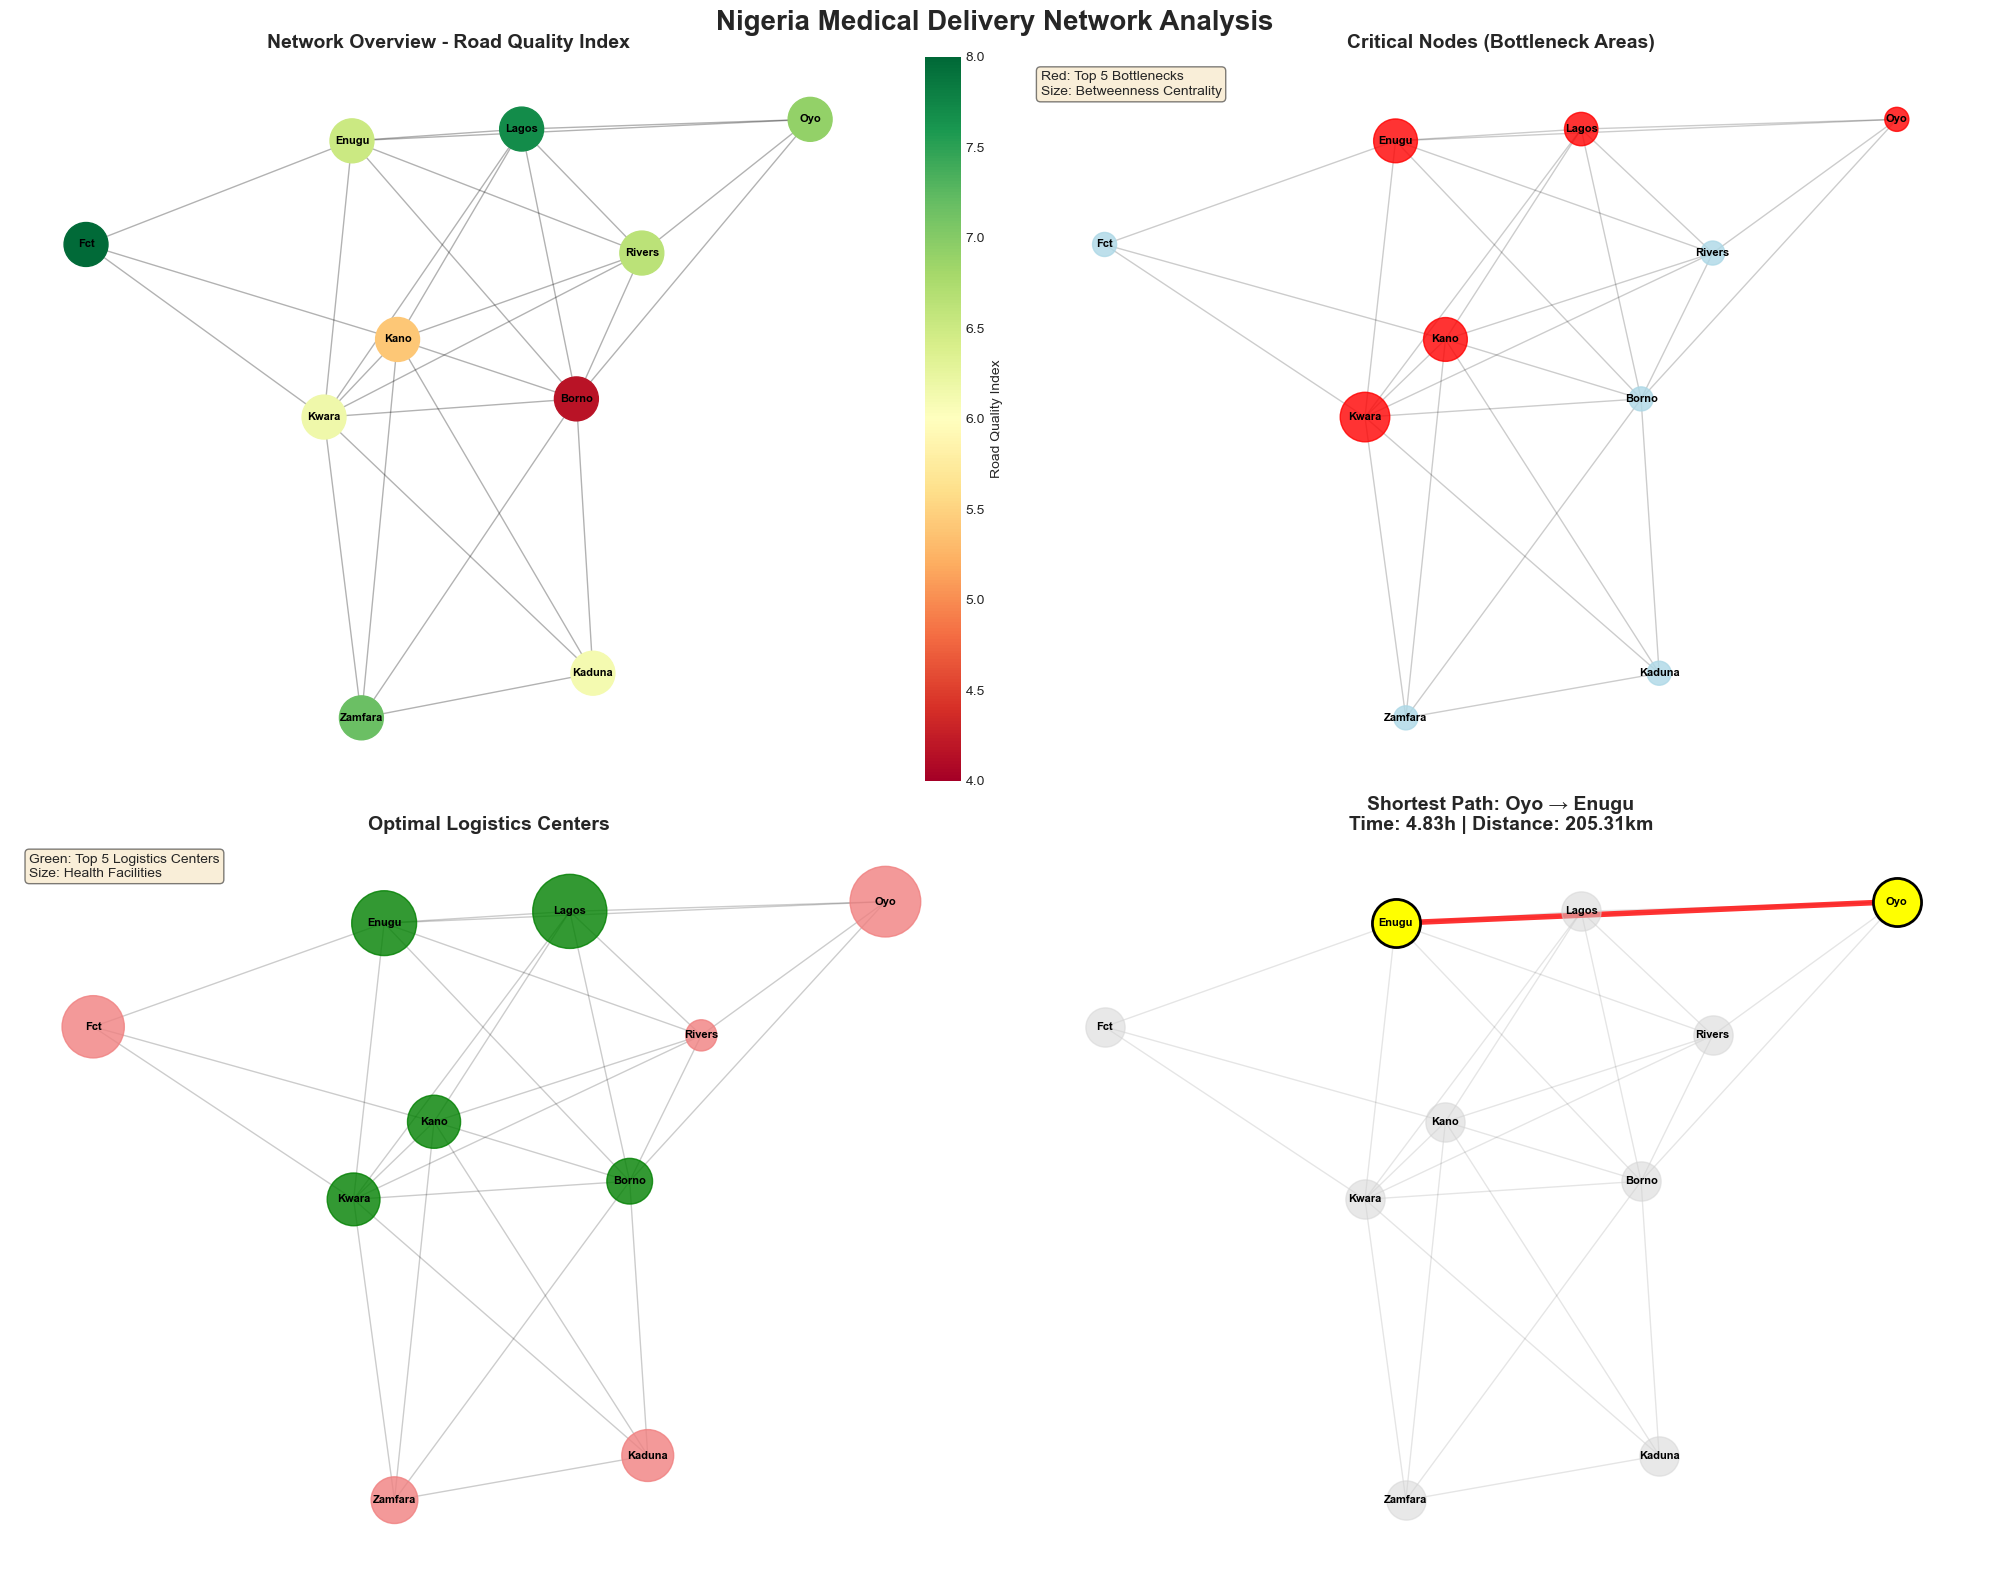


 Exporting analysis results...
 Critical nodes exported to 'critical_nodes_analysis.csv'
 Logistics centers exported to 'logistics_centers_ranking.csv'

ANALYSIS COMPLETE!


In [19]:
"""
Nigeria Medical Delivery Network - Weighted Graph Model
Implements Dijkstra's Algorithm for optimal route planning
"""

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class MedicalDeliveryNetwork:
    def __init__(self, csv_path):
        """Initialize the medical delivery network"""
        # Try different encodings to handle the file
        encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252', 'windows-1252']
        
        for encoding in encodings:
            try:
                self.df = pd.read_csv(csv_path, encoding=encoding, encoding_errors='ignore')
                print(f" Successfully loaded CSV with {encoding} encoding")
                break
            except UnicodeDecodeError:
                continue
            except Exception as e:
                if encoding == encodings[-1]:
                    raise Exception(f"Failed to load CSV with all encodings: {e}")
        
        self.G = nx.Graph()
        self.state_facilities = defaultdict(int)
        self.road_quality = {}
        self.delivery_times = {}
        
    def preprocess_data(self):
        """Clean and prepare the data"""
        print(" Preprocessing Health Facility Data...")
        
        # Display data info
        print(f"Total Records: {len(self.df)}")
        print(f"Columns: {self.df.columns.tolist()}")
        
        # Identify state column (common names: State, state, State_Name, etc.)
        state_col = None
        for col in self.df.columns:
            if 'state' in col.lower():
                state_col = col
                break
        
        if state_col is None:
            print(" State column not found. Using first column.")
            state_col = self.df.columns[0]
        
        print(f"Using '{state_col}' as state column")
        
        # Count facilities per state
        self.state_facilities = self.df[state_col].value_counts().to_dict()
        
        # Focus on major states with significant facilities
        major_states = dict(sorted(self.state_facilities.items(), 
                                   key=lambda x: x[1], reverse=True)[:15])
        
        print(f"\n Top 15 States by Health Facilities:")
        for state, count in list(major_states.items())[:5]:
            print(f"  {state}: {count} facilities")
        
        return list(major_states.keys()), major_states
    
    def simulate_road_quality(self, states):
        """
        Simulate road quality index based on state characteristics
        Scale: 1-10 (10 = excellent roads)
        """
        # Known road quality estimates for Nigerian states
        road_quality_map = {
            'Lagos': 7.5, 'Abuja': 8.0, 'Rivers': 6.5, 'Kano': 5.5,
            'Kaduna': 6.0, 'Oyo': 6.5, 'Delta': 5.0, 'Edo': 6.0,
            'Anambra': 7.0, 'Enugu': 6.8, 'Abia': 6.2, 'Ondo': 5.8,
            'Osun': 6.3, 'Ogun': 7.0, 'Plateau': 5.5, 'Benue': 5.0,
            'Cross River': 5.5, 'Akwa Ibom': 6.5, 'Imo': 6.0, 'Kwara': 6.2,
            'Bayelsa': 4.5, 'Ekiti': 5.8, 'Niger': 5.5, 'Taraba': 4.8,
            'Nasarawa': 5.5, 'Adamawa': 5.0, 'Borno': 4.5, 'Yobe': 4.5
        }
        
        for state in states:
            # Use known quality or estimate based on facilities (more facilities = better infrastructure)
            if state in road_quality_map:
                quality = road_quality_map[state]
            else:
                # Estimate: states with more facilities tend to have better roads
                facility_count = self.state_facilities.get(state, 0)
                quality = min(8.0, 4.0 + (facility_count / 100))
            
            self.road_quality[state] = round(quality + np.random.uniform(-0.5, 0.5), 2)
    
    def calculate_delivery_time(self, state1, state2, distance_km):
        """
        Calculate delivery time based on distance and road quality
        Formula: time = (distance / speed) + road_quality_penalty
        """
        avg_road_quality = (self.road_quality[state1] + self.road_quality[state2]) / 2
        
        # Base speed: 60 km/h, reduced by poor road quality
        effective_speed = 40 + (avg_road_quality * 2)  # 40-60 km/h range
        
        # Calculate time in hours
        base_time = distance_km / effective_speed
        
        # Add road quality penalty (worse roads = more delays)
        road_penalty = (10 - avg_road_quality) * 0.3
        
        total_time = base_time + road_penalty
        return round(total_time, 2)
    
    def estimate_distance(self, state1, state2):
        """
        Estimate distance between states based on geographic regions
        Simplified model - in production, use actual coordinates
        """
        # Regional groupings
        regions = {
            'South-West': ['Lagos', 'Oyo', 'Ogun', 'Ondo', 'Osun', 'Ekiti'],
            'South-South': ['Rivers', 'Delta', 'Edo', 'Cross River', 'Akwa Ibom', 'Bayelsa'],
            'South-East': ['Anambra', 'Enugu', 'Abia', 'Imo', 'Ebonyi'],
            'North-Central': ['Abuja', 'Niger', 'Kogi', 'Kwara', 'Nasarawa', 'Plateau', 'Benue'],
            'North-West': ['Kano', 'Kaduna', 'Katsina', 'Sokoto', 'Zamfara', 'Kebbi', 'Jigawa'],
            'North-East': ['Borno', 'Yobe', 'Adamawa', 'Bauchi', 'Gombe', 'Taraba']
        }
        
        # Find regions
        region1 = region2 = None
        for region, states in regions.items():
            if state1 in states:
                region1 = region
            if state2 in states:
                region2 = region
        
        # Estimate distance
        if region1 == region2:
            # Within same region
            return np.random.uniform(80, 200)
        elif (region1 in ['South-West', 'South-South', 'South-East'] and 
              region2 in ['South-West', 'South-South', 'South-East']):
            # Between southern regions
            return np.random.uniform(200, 400)
        elif (region1 in ['North-West', 'North-Central', 'North-East'] and 
              region2 in ['North-West', 'North-Central', 'North-East']):
            # Between northern regions
            return np.random.uniform(200, 450)
        else:
            # North-South connections
            return np.random.uniform(400, 800)
    
    def build_network(self, states):
        """Build the weighted graph network"""
        print("\n Building Medical Delivery Network...")
        
        # Add nodes (states) with attributes
        for state in states:
            self.G.add_node(state, 
                          facilities=self.state_facilities[state],
                          road_quality=self.road_quality[state])
        
        # Add edges between states (connectivity based on geographic proximity)
        # Connect states that are likely to have delivery routes
        edges_added = 0
        
        for i, state1 in enumerate(states):
            for state2 in states[i+1:]:
                # Estimate distance
                distance = self.estimate_distance(state1, state2)
                
                # Only connect if distance is reasonable for delivery routes
                if distance < 600:  # Max 600km for direct routes
                    delivery_time = self.calculate_delivery_time(state1, state2, distance)
                    
                    # Weight combines time and inverse road quality
                    # Lower weight = better route
                    avg_road_quality = (self.road_quality[state1] + self.road_quality[state2]) / 2
                    weight = delivery_time * (1 + (10 - avg_road_quality) / 10)
                    
                    self.G.add_edge(state1, state2, 
                                  weight=round(weight, 2),
                                  distance=round(distance, 2),
                                  delivery_time=delivery_time,
                                  road_quality=round(avg_road_quality, 2))
                    edges_added += 1
        
        print(f" Network built: {len(self.G.nodes)} nodes, {len(self.G.edges)} edges")
        return self.G
    
    def dijkstra_shortest_path(self, source, target):
        """
        Implement Dijkstra's Algorithm for shortest path
        Returns: path, total_time, total_distance
        """
        try:
            # Find shortest path
            path = nx.dijkstra_path(self.G, source, target, weight='weight')
            
            # Calculate total metrics
            total_time = 0
            total_distance = 0
            route_details = []
            
            for i in range(len(path) - 1):
                edge_data = self.G[path[i]][path[i+1]]
                total_time += edge_data['delivery_time']
                total_distance += edge_data['distance']
                route_details.append({
                    'from': path[i],
                    'to': path[i+1],
                    'distance': edge_data['distance'],
                    'time': edge_data['delivery_time'],
                    'road_quality': edge_data['road_quality']
                })
            
            return {
                'path': path,
                'total_time': round(total_time, 2),
                'total_distance': round(total_distance, 2),
                'route_details': route_details
            }
        except nx.NetworkXNoPath:
            return None
    
    def identify_critical_nodes(self):
        """Identify bottleneck areas using centrality measures"""
        print("\n Identifying Critical Nodes (Bottlenecks)...")
        
        # Betweenness centrality - nodes that appear in many shortest paths
        betweenness = nx.betweenness_centrality(self.G, weight='weight')
        
        # Degree centrality - nodes with many connections
        degree = nx.degree_centrality(self.G)
        
        # Closeness centrality - nodes with short paths to all others
        closeness = nx.closeness_centrality(self.G, distance='weight')
        
        # Combine metrics
        critical_scores = {}
        for node in self.G.nodes():
            critical_scores[node] = {
                'betweenness': round(betweenness[node], 4),
                'degree': round(degree[node], 4),
                'closeness': round(closeness[node], 4),
                'facilities': self.state_facilities[node],
                'road_quality': self.road_quality[node]
            }
        
        # Sort by betweenness (bottleneck indicator)
        sorted_critical = sorted(critical_scores.items(), 
                               key=lambda x: x[1]['betweenness'], 
                               reverse=True)
        
        print("\n Top 5 Bottleneck States:")
        for state, metrics in sorted_critical[:5]:
            print(f"  {state}:")
            print(f"    - Betweenness: {metrics['betweenness']:.4f}")
            print(f"    - Facilities: {metrics['facilities']}")
            print(f"    - Road Quality: {metrics['road_quality']}/10")
        
        return critical_scores, sorted_critical
    
    def identify_logistics_centers(self):
        """Identify optimal logistics center locations"""
        print("\n Identifying Efficient Logistics Centers...")
        
        # Criteria for good logistics centers:
        # 1. High closeness centrality (easy to reach from everywhere)
        # 2. Many health facilities
        # 3. Good road quality
        # 4. High degree (many connections)
        
        closeness = nx.closeness_centrality(self.G, distance='weight')
        degree = nx.degree_centrality(self.G)
        
        logistics_scores = {}
        for node in self.G.nodes():
            # Normalize and combine factors
            facility_score = min(self.state_facilities[node] / 200, 1.0)
            road_score = self.road_quality[node] / 10
            
            total_score = (closeness[node] * 0.35 + 
                          degree[node] * 0.25 + 
                          facility_score * 0.25 + 
                          road_score * 0.15)
            
            logistics_scores[node] = {
                'total_score': round(total_score, 4),
                'closeness': round(closeness[node], 4),
                'degree': round(degree[node], 4),
                'facilities': self.state_facilities[node],
                'road_quality': self.road_quality[node]
            }
        
        sorted_logistics = sorted(logistics_scores.items(), 
                                 key=lambda x: x[1]['total_score'], 
                                 reverse=True)
        
        print("\n Top 5 Recommended Logistics Centers:")
        for state, metrics in sorted_logistics[:5]:
            print(f"  {state}:")
            print(f"    - Overall Score: {metrics['total_score']:.4f}")
            print(f"    - Centrality: {metrics['closeness']:.4f}")
            print(f"    - Facilities: {metrics['facilities']}")
            print(f"    - Road Quality: {metrics['road_quality']}/10")
        
        return logistics_scores, sorted_logistics
    
    def visualize_network(self, critical_nodes, logistics_centers, 
                         highlight_path=None):
        """Create comprehensive network visualization"""
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        fig.suptitle('Nigeria Medical Delivery Network Analysis', 
                    fontsize=20, fontweight='bold')
        
        # Prepare node positions using spring layout
        pos = nx.spring_layout(self.G, k=2, iterations=50, seed=42)
        
        # --- Plot 1: Full Network with Road Quality ---
        ax1 = axes[0, 0]
        node_colors = [self.road_quality[node] for node in self.G.nodes()]
        
        nx.draw_networkx_nodes(self.G, pos, 
                              node_color=node_colors,
                              node_size=1000,
                              cmap='RdYlGn',
                              vmin=4, vmax=8,
                              ax=ax1)
        
        nx.draw_networkx_edges(self.G, pos, 
                              width=1, 
                              alpha=0.3,
                              ax=ax1)
        
        nx.draw_networkx_labels(self.G, pos, 
                               font_size=8,
                               font_weight='bold',
                               ax=ax1)
        
        ax1.set_title('Network Overview - Road Quality Index', fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap='RdYlGn', 
                                   norm=plt.Normalize(vmin=4, vmax=8))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax1, fraction=0.046, pad=0.04)
        cbar.set_label('Road Quality Index', fontsize=10)
        
        # --- Plot 2: Critical Nodes (Bottlenecks) ---
        ax2 = axes[0, 1]
        
        # Size nodes by betweenness centrality
        betweenness = nx.betweenness_centrality(self.G, weight='weight')
        node_sizes = [betweenness[node] * 5000 + 300 for node in self.G.nodes()]
        
        # Top 5 bottlenecks in red
        top_bottlenecks = [node[0] for node in critical_nodes[:5]]
        node_colors = ['red' if node in top_bottlenecks else 'lightblue' 
                      for node in self.G.nodes()]
        
        nx.draw_networkx_nodes(self.G, pos,
                              node_size=node_sizes,
                              node_color=node_colors,
                              alpha=0.8,
                              ax=ax2)
        
        nx.draw_networkx_edges(self.G, pos,
                              width=1,
                              alpha=0.2,
                              ax=ax2)
        
        nx.draw_networkx_labels(self.G, pos,
                               font_size=8,
                               font_weight='bold',
                               ax=ax2)
        
        ax2.set_title('Critical Nodes (Bottleneck Areas)', fontsize=14, fontweight='bold')
        ax2.axis('off')
        
        # Add legend
        legend_text = "Red: Top 5 Bottlenecks\nSize: Betweenness Centrality"
        ax2.text(0.02, 0.98, legend_text, transform=ax2.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # --- Plot 3: Logistics Centers ---
        ax3 = axes[1, 0]
        
        # Top 5 logistics centers in green
        top_logistics = [node[0] for node in logistics_centers[:5]]
        node_colors = ['green' if node in top_logistics else 'lightcoral' 
                      for node in self.G.nodes()]
        
        # Size by facility count
        node_sizes = [self.state_facilities[node] * 3 + 300 for node in self.G.nodes()]
        
        nx.draw_networkx_nodes(self.G, pos,
                              node_size=node_sizes,
                              node_color=node_colors,
                              alpha=0.8,
                              ax=ax3)
        
        nx.draw_networkx_edges(self.G, pos,
                              width=1,
                              alpha=0.2,
                              ax=ax3)
        
        nx.draw_networkx_labels(self.G, pos,
                               font_size=8,
                               font_weight='bold',
                               ax=ax3)
        
        ax3.set_title('Optimal Logistics Centers', fontsize=14, fontweight='bold')
        ax3.axis('off')
        
        legend_text = "Green: Top 5 Logistics Centers\nSize: Health Facilities"
        ax3.text(0.02, 0.98, legend_text, transform=ax3.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # --- Plot 4: Shortest Path Example (if provided) ---
        ax4 = axes[1, 1]
        
        if highlight_path:
            path = highlight_path['path']
            
            # Draw all nodes in light gray
            nx.draw_networkx_nodes(self.G, pos,
                                  node_size=800,
                                  node_color='lightgray',
                                  alpha=0.5,
                                  ax=ax4)
            
            # Highlight path nodes
            nx.draw_networkx_nodes(self.G, pos,
                                  nodelist=path,
                                  node_size=1200,
                                  node_color='yellow',
                                  edgecolors='black',
                                  linewidths=2,
                                  ax=ax4)
            
            # Draw all edges in light gray
            nx.draw_networkx_edges(self.G, pos,
                                  width=1,
                                  alpha=0.1,
                                  ax=ax4)
            
            # Highlight path edges
            path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
            nx.draw_networkx_edges(self.G, pos,
                                  edgelist=path_edges,
                                  width=4,
                                  edge_color='red',
                                  alpha=0.8,
                                  ax=ax4)
            
            nx.draw_networkx_labels(self.G, pos,
                                   font_size=8,
                                   font_weight='bold',
                                   ax=ax4)
            
            title = f"Shortest Path: {path[0]} → {path[-1]}"
            subtitle = f"Time: {highlight_path['total_time']}h | Distance: {highlight_path['total_distance']}km"
            ax4.set_title(f"{title}\n{subtitle}", fontsize=14, fontweight='bold')
        else:
            # Show facility distribution
            facilities = [self.state_facilities[node] for node in self.G.nodes()]
            
            nx.draw_networkx_nodes(self.G, pos,
                                  node_size=facilities,
                                  node_color=facilities,
                                  cmap='YlOrRd',
                                  alpha=0.7,
                                  ax=ax4)
            
            nx.draw_networkx_edges(self.G, pos,
                                  width=1,
                                  alpha=0.2,
                                  ax=ax4)
            
            nx.draw_networkx_labels(self.G, pos,
                                   font_size=8,
                                   font_weight='bold',
                                   ax=ax4)
            
            ax4.set_title('Health Facility Distribution', fontsize=14, fontweight='bold')
        
        ax4.axis('off')
        
        plt.tight_layout()
        return fig


def main():
    """Main execution function"""
    
    # File path
    csv_path = r"C:\Users\hp\Desktop\doub_PDF\HealthFacility.csv"
    
    print("=" * 60)
    print("NIGERIA MEDICAL DELIVERY NETWORK ANALYSIS")
    print("=" * 60)
    
    # Initialize network
    network = MedicalDeliveryNetwork(csv_path)
    
    # Step 1: Preprocess data
    states, facilities_dict = network.preprocess_data()
    
    # Step 2: Simulate road quality
    network.simulate_road_quality(states)
    
    # Step 3: Build network
    G = network.build_network(states)
    
    # Step 4: Identify critical nodes
    critical_scores, sorted_critical = network.identify_critical_nodes()
    
    # Step 5: Identify logistics centers
    logistics_scores, sorted_logistics = network.identify_logistics_centers()
    
    # Step 6: Compute shortest path (Example: Oyo → Enugu)
    print("\n" + "=" * 60)
    print("DIJKSTRA'S ALGORITHM: SHORTEST PATH COMPUTATION")
    print("=" * 60)
    
    source = 'Oyo'
    target = 'Enugu'
    
    if source in states and target in states:
        result = network.dijkstra_shortest_path(source, target)
        
        if result:
            print(f"\n Optimal Route: {source} → {target}")
            print(f"   Path: {' → '.join(result['path'])}")
            print(f"   Total Time: {result['total_time']} hours")
            print(f"   Total Distance: {result['total_distance']} km")
            print(f"\n   Route Breakdown:")
            for i, leg in enumerate(result['route_details'], 1):
                print(f"   {i}. {leg['from']} → {leg['to']}")
                print(f"      Distance: {leg['distance']}km | Time: {leg['time']}h | Road Quality: {leg['road_quality']}/10")
        else:
            print(f" No path found between {source} and {target}")
            result = None
    else:
        print(f" States {source} or {target} not in network")
        result = None
    
    # Step 7: Visualize
    print("\n Generating network visualizations...")
    fig = network.visualize_network(sorted_critical, sorted_logistics, result)
    plt.savefig('nigeria_medical_network.png', dpi=300, bbox_inches='tight')
    print(" Visualization saved as 'nigeria_medical_network.png'")
    
    plt.show()
    
    # Step 8: Export results
    print("\n Exporting analysis results...")
    
    # Export critical nodes
    critical_df = pd.DataFrame([
        {
            'State': state,
            'Betweenness_Centrality': metrics['betweenness'],
            'Degree_Centrality': metrics['degree'],
            'Closeness_Centrality': metrics['closeness'],
            'Health_Facilities': metrics['facilities'],
            'Road_Quality': metrics['road_quality']
        }
        for state, metrics in sorted_critical
    ])
    critical_df.to_csv('critical_nodes_analysis.csv', index=False)
    print(" Critical nodes exported to 'critical_nodes_analysis.csv'")
    
    # Export logistics centers
    logistics_df = pd.DataFrame([
        {
            'State': state,
            'Logistics_Score': metrics['total_score'],
            'Centrality_Score': metrics['closeness'],
            'Connectivity': metrics['degree'],
            'Health_Facilities': metrics['facilities'],
            'Road_Quality': metrics['road_quality']
        }
        for state, metrics in sorted_logistics
    ])
    logistics_df.to_csv('logistics_centers_ranking.csv', index=False)
    print(" Logistics centers exported to 'logistics_centers_ranking.csv'")
    
    print("\n" + "=" * 60)
    print("ANALYSIS COMPLETE!")
    print("=" * 60)


if __name__ == "__main__":
    main()

**Alternate Routes (Avoiding Flood-Prone Areas)**

*Delivery routes where main roads are flood-prone or broken*

Loaded: C:\Users\hp\medical_delivery_final.csv | shape: (4563, 9)
Columns: ['State', 'LGA', 'Facility_Name', 'Road_Quality', 'Distance_km', 'Delivery_Time_hr', 'Flood_Risk_Score', 'Latitude', 'Longitude']
Using state column: State
Detected road quality column: Road_Quality
Detected flood risk column: Flood_Risk_Score

Selected states (top 15):
['Lagos', 'Oyo', 'Enugu', 'Fct', 'Kano', 'Kwara', 'Kaduna', 'Zamfara', 'Borno', 'Rivers', 'Ekiti', 'Ondo', 'Osun', 'Bauchi', 'Akwa Ibom']

Graph: nodes=15, edges=79

Thresholds -> flood (75%): 0.667, road_quality (25%): 5.025
Edge status counts: {'flooded': 18, 'ok': 50, 'broken': 11}

Using source: Oyo  target: Enugu

Main path exists: True
Main path: Oyo -> Enugu
Total time (h): 6.1 | distance (km): 236.36
Problems on main path: [('Oyo', 'Enugu', 'flooded')]

Alternatives found: 3
 Alternative 1: Oyo -> Ondo -> Enugu | time 11.95 h | distance 485.64 km
 Alternative 2: Oyo -> Akwa Ibom -> Enugu | time 13.37 h | distance 576.78 km
 Alternative 3:

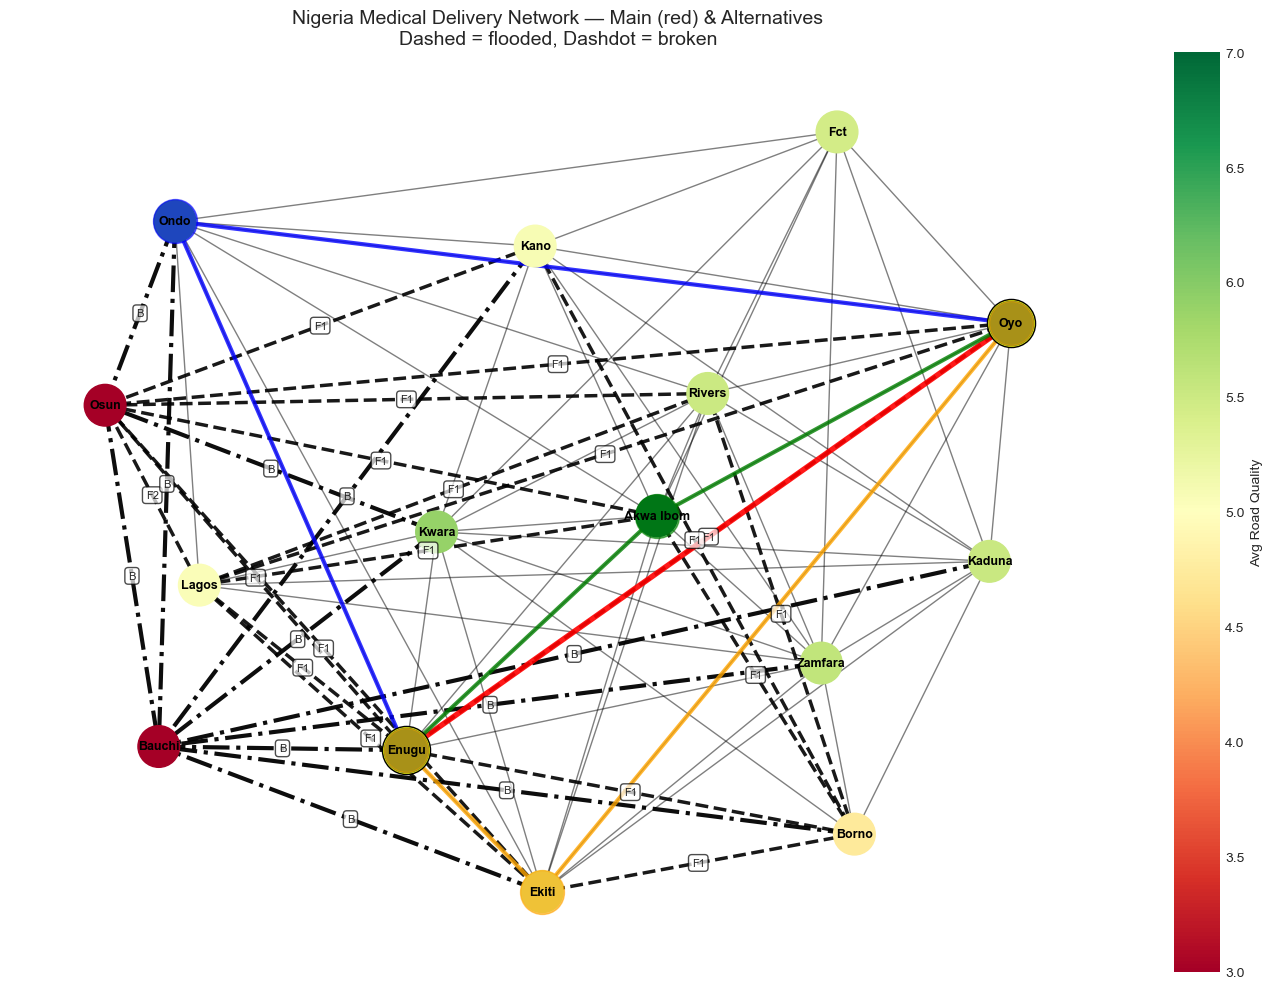

Saved critical nodes to: C:\Users\hp\Desktop\doub_PDF\critical_nodes_analysis.csv
Saved logistics centers ranking to: C:\Users\hp\Desktop\doub_PDF\logistics_centers_ranking.csv

Done — outputs saved in: C:\Users\hp\Desktop\doub_PDF


In [20]:
# Paste / run this entire cell in Jupyter.
# Robust handling for non-numeric Road_Quality and Flood_Risk_Score values,
# then build graph + find alternate routes as before.

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import os
import re

random.seed(42)
np.random.seed(42)

CSV_PATH = r"C:\Users\hp\medical_delivery_final.csv"
OUT_DIR = r"C:\Users\hp\Desktop\doub_PDF"
TOP_N_STATES = 15
SOURCE = "Oyo"
TARGET = "Enugu"
K_ALTERNATIVES = 3

os.makedirs(OUT_DIR, exist_ok=True)

# Helper: robust numeric conversion for messy columns
def series_to_numeric(series, target_scale='1-10', prefer_percent=False):
    """
    Convert a pandas Series with mixed types (numbers, strings like 'Good', '75%', '4/10', '6 - 7')
    to numeric values.

    target_scale: '1-10' -> returns values roughly in 1..10
                  '0-1'  -> returns values roughly in 0..1 (useful for flood risk)
    prefer_percent: if True, strings like '75' or '75%' will be interpreted as percent (0.75 or 7.5)
                    depending on target_scale.
    """
    s = series.astype(str).str.strip().replace({'nan':'', 'None':''})
    numeric = pd.to_numeric(s.str.replace('%','').str.extract(r'([-+]?\d*\.?\d+)', expand=False), errors='coerce')

    # For entries that are still non-numeric, map common categories:
    cat_map_1_10 = {
        'excellent': 9.0, 'very good': 8.5, 'verygood': 8.5, 'good': 7.0,
        'fair': 5.0, 'average': 5.0, 'moderate': 5.5, 'poor': 3.0,
        'bad': 2.0, 'very poor': 1.0, 'verypoor': 1.0, 'unknown': np.nan
    }
    cat_map_0_1 = {
        'high': 0.9, 'medium': 0.5, 'moderate': 0.5, 'low': 0.1,
        'very high': 0.95, 'very low': 0.05
    }

    # Prepare result series
    result = pd.Series(index=series.index, dtype=float)

    for idx, raw in s.items():
        val = numeric.loc[idx]
        if not pd.isna(val):
            # If it's an extracted number, interpret heuristically
            # If it was percent-like (contained '%') or prefer_percent, handle as percent
            raw_str = str(series.loc[idx])
            if '%' in raw_str:
                # percent present: convert to 0..1 or 1..10 depending on target_scale
                pct = float(val) / 100.0
                if target_scale == '1-10':
                    result.loc[idx] = pct * 10.0
                else:
                    result.loc[idx] = pct
            else:
                # if value looks like 0..1 and target_scale is 1-10, scale up
                if target_scale == '1-10':
                    if val <= 1.1:
                        result.loc[idx] = float(val) * 10.0
                    elif val <= 10.0:
                        result.loc[idx] = float(val)
                    else:
                        # if value > 10, normalize to 1-10 by cap
                        result.loc[idx] = min(float(val), 10.0)
                else:  # target_scale == '0-1'
                    if val > 1.1:
                        # interpret as percentage 0..100 -> 0..1
                        result.loc[idx] = min(float(val) / 100.0, 1.0)
                    else:
                        result.loc[idx] = float(val)
        else:
            # non-numeric string -> try categorical map
            key = raw.strip().lower()
            key = re.sub(r'[^a-z0-9 ]','', key)
            if target_scale == '1-10':
                mapped = cat_map_1_10.get(key, np.nan)
                result.loc[idx] = mapped
            else:
                mapped = cat_map_0_1.get(key, np.nan)
                result.loc[idx] = mapped

    return result

# Load CSV
df = pd.read_csv(CSV_PATH, encoding_errors='ignore')
print("Loaded:", CSV_PATH, "| shape:", df.shape)
print("Columns:", df.columns.tolist())

# Identify state, road quality, flood columns
state_col = None
for col in df.columns:
    if 'state' in col.lower() or col.lower() in ('state','state_name'):
        state_col = col
        break
if state_col is None:
    candidate_counts = sorted([(c, df[c].nunique()) for c in df.columns], key=lambda x: x[1])
    for c,n in candidate_counts:
        if 2 <= n <= 200:
            state_col = c
            break
if state_col is None:
    state_col = df.columns[0]
print("Using state column:", state_col)

# Detect possible columns
rq_col = None
fr_col = None
for col in df.columns:
    name = col.lower()
    if ('road' in name and 'quality' in name) or name == 'road_quality':
        rq_col = col
    if 'flood' in name and ('risk' in name or 'score' in name):
        fr_col = col

print("Detected road quality column:", rq_col)
print("Detected flood risk column:", fr_col)

# Normalize state text
df[state_col] = df[state_col].astype(str).str.strip()

# Create state-level aggregates
state_facilities = df[state_col].value_counts().to_dict()
state_df = pd.DataFrame.from_dict(state_facilities, orient='index', columns=['facility_count'])
state_df.index.name = 'state'
state_df.reset_index(inplace=True)

# Convert road quality/flood risk to numeric robustly
if rq_col and rq_col in df.columns:
    converted_rq = series_to_numeric(df[rq_col], target_scale='1-10')
    df['_rq_clean'] = converted_rq
    avg_rq = df.groupby(state_col)['_rq_clean'].mean().rename('avg_road_quality')
    state_df = state_df.merge(avg_rq.reset_index().rename(columns={state_col:'state'}), on='state', how='left')
else:
    state_df['avg_road_quality'] = np.nan

if fr_col and fr_col in df.columns:
    converted_fr = series_to_numeric(df[fr_col], target_scale='0-1')
    df['_fr_clean'] = converted_fr
    avg_fr = df.groupby(state_col)['_fr_clean'].mean().rename('avg_flood_risk')
    state_df = state_df.merge(avg_fr.reset_index().rename(columns={state_col:'state'}), on='state', how='left')
else:
    state_df['avg_flood_risk'] = np.nan

# Fill missing road quality using facility heuristic (more facilities -> likely better roads)
state_df['avg_road_quality'] = state_df['avg_road_quality'].fillna(
    state_df['facility_count'].apply(lambda c: min(8.0, 4.0 + (c / 100.0)))
)

# Fill missing flood risk inversely from road quality, clipped 0..1
state_df['avg_flood_risk'] = state_df['avg_flood_risk'].fillna(
    ((10.0 - state_df['avg_road_quality']) / 10.0)
).clip(0.0, 1.0)

# If road_quality values seem out of 0..1 after conversion, ensure they are 1..10 scale
rq_min, rq_max = state_df['avg_road_quality'].min(), state_df['avg_road_quality'].max()
if rq_max <= 1.1:
    state_df['avg_road_quality'] = state_df['avg_road_quality'] * 10.0

# Select top N states
top_states_df = state_df.sort_values('facility_count', ascending=False).head(TOP_N_STATES)
states = top_states_df['state'].tolist()
print("\nSelected states (top {}):".format(len(states)))
print(states)

# Build Graph
G = nx.Graph()
for _, r in top_states_df.iterrows():
    G.add_node(r['state'], facilities=int(r['facility_count']), avg_road_quality=float(r['avg_road_quality']), avg_flood_risk=float(r['avg_flood_risk']))

# Distance estimator (same as previous heuristics)
def estimate_distance(s1, s2):
    regions = {
        'South-West': ['Lagos', 'Oyo', 'Ogun', 'Ondo', 'Osun', 'Ekiti'],
        'South-South': ['Rivers', 'Delta', 'Edo', 'Cross River', 'Akwa Ibom', 'Bayelsa'],
        'South-East': ['Anambra', 'Enugu', 'Abia', 'Imo', 'Ebonyi'],
        'North-Central': ['Abuja', 'Niger', 'Kogi', 'Kwara', 'Nasarawa', 'Plateau', 'Benue'],
        'North-West': ['Kano', 'Kaduna', 'Katsina', 'Sokoto', 'Zamfara', 'Kebbi', 'Jigawa'],
        'North-East': ['Borno', 'Yobe', 'Adamawa', 'Bauchi', 'Gombe', 'Taraba']
    }
    r1 = r2 = None
    for reg, stlist in regions.items():
        if s1 in stlist: r1 = reg
        if s2 in stlist: r2 = reg
    if r1 == r2 and r1 is not None:
        return float(np.random.uniform(80,200))
    elif (r1 in ['South-West','South-South','South-East'] and r2 in ['South-West','South-South','South-East']):
        return float(np.random.uniform(200,400))
    elif (r1 in ['North-West','North-Central','North-East'] and r2 in ['North-West','North-Central','North-East']):
        return float(np.random.uniform(200,450))
    else:
        return float(np.random.uniform(400,800))

def calc_delivery_time(s1, s2, dist_km):
    avg_rq = (G.nodes[s1]['avg_road_quality'] + G.nodes[s2]['avg_road_quality']) / 2.0
    effective_speed = 40.0 + (avg_rq * 2.0)
    base_time = dist_km / effective_speed
    road_penalty = (10.0 - avg_rq) * 0.3
    return round(base_time + road_penalty, 2)

# Add edges
for i, s1 in enumerate(states):
    for s2 in states[i+1:]:
        dist = estimate_distance(s1, s2)
        if dist < 600:
            dt = calc_delivery_time(s1, s2, dist)
            avg_rq = round((G.nodes[s1]['avg_road_quality'] + G.nodes[s2]['avg_road_quality']) / 2.0, 2)
            weight = dt * (1.0 + (10.0 - avg_rq) / 10.0)
            G.add_edge(s1, s2, distance=round(dist,2), delivery_time=dt, road_quality=avg_rq, weight=round(weight,2), status='ok', issue_severity=0)

print("\nGraph: nodes={}, edges={}".format(G.number_of_nodes(), G.number_of_edges()))

# Deterministic marking using quantiles (as before)
node_attrs = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
flood_q75 = node_attrs['avg_flood_risk'].quantile(0.75)
rq_q25 = node_attrs['avg_road_quality'].quantile(0.25)
print("\nThresholds -> flood (75%): {:.3f}, road_quality (25%): {:.3f}".format(float(flood_q75), float(rq_q25)))

for u, v, d in G.edges(data=True):
    avg_flood = (G.nodes[u]['avg_flood_risk'] + G.nodes[v]['avg_flood_risk']) / 2.0
    avg_rq = d.get('road_quality', 6.0)
    if avg_flood >= flood_q75:
        excess = (avg_flood - flood_q75) / (max(1e-6, 1.0 - flood_q75))
        severity = int(np.clip(np.ceil(excess * 3.0), 1, 3))
        G[u][v]['status'] = 'flooded'
        G[u][v]['issue_severity'] = int(severity)
    elif avg_rq <= rq_q25:
        G[u][v]['status'] = 'broken'
        G[u][v]['issue_severity'] = 0
    else:
        G[u][v]['status'] = 'ok'
        G[u][v]['issue_severity'] = 0

# Summary counts
status_counts = defaultdict(int)
for _, _, d in G.edges(data=True):
    status_counts[d['status']] += 1
print("Edge status counts:", dict(status_counts))

# Dijkstra and alternatives (same as earlier)
def dijkstra_path_with_details(G, source, target):
    try:
        path = nx.dijkstra_path(G, source, target, weight='weight')
    except nx.NetworkXNoPath:
        return None
    total_time = sum(G[path[i]][path[i+1]]['delivery_time'] for i in range(len(path)-1))
    total_distance = sum(G[path[i]][path[i+1]]['distance'] for i in range(len(path)-1))
    details = []
    for i in range(len(path)-1):
        ed = G[path[i]][path[i+1]]
        details.append({
            'from': path[i], 'to': path[i+1],
            'distance_km': ed['distance'],
            'time_h': ed['delivery_time'],
            'road_quality': ed['road_quality'],
            'status': ed['status'],
            'severity': ed['issue_severity']
        })
    return {'path': path, 'total_time': round(total_time,2), 'total_distance': round(total_distance,2), 'details': details}

def find_alternatives(G, source, target, k=3, avoid_statuses=('flooded','broken')):
    main = dijkstra_path_with_details(G, source, target)
    problems_on_main = []
    if main:
        for leg in main['details']:
            if leg['status'] in avoid_statuses:
                problems_on_main.append((leg['from'], leg['to'], leg['status']))
    G_clean = G.copy()
    edges_to_remove = [(u,v) for u,v,d in G.edges(data=True) if d['status'] in avoid_statuses]
    G_clean.remove_edges_from(edges_to_remove)
    alternatives = []
    try:
        gen = nx.shortest_simple_paths(G_clean, source, target, weight='weight')
        for path in gen:
            total_time = sum(G[path[i]][path[i+1]]['delivery_time'] for i in range(len(path)-1))
            total_distance = sum(G[path[i]][path[i+1]]['distance'] for i in range(len(path)-1))
            alternatives.append({'path': path, 'total_time': round(total_time,2), 'total_distance': round(total_distance,2)})
            if len(alternatives) >= k:
                break
    except Exception:
        pass
    if not alternatives:
        G_relax = G.copy()
        broken_edges = [(u,v) for u,v,d in G.edges(data=True) if d['status'] == 'broken']
        G_relax.remove_edges_from(broken_edges)
        try:
            gen = nx.shortest_simple_paths(G_relax, source, target, weight='weight')
            for path in gen:
                total_time = sum(G[path[i]][path[i+1]]['delivery_time'] for i in range(len(path)-1))
                total_distance = sum(G[path[i]][path[i+1]]['distance'] for i in range(len(path)-1))
                alternatives.append({'path': path, 'total_time': round(total_time,2), 'total_distance': round(total_distance,2)})
                if len(alternatives) >= k:
                    break
        except Exception:
            pass
    return {'main': main, 'alternatives': alternatives, 'problems_on_main': problems_on_main}

# Choose source/target that exist in graph nodes
if SOURCE in G.nodes() and TARGET in G.nodes():
    src, tgt = SOURCE, TARGET
else:
    nodes_list = list(G.nodes())
    if len(nodes_list) >= 2:
        src, tgt = nodes_list[0], nodes_list[1]
    else:
        src = tgt = nodes_list[0]
print("\nUsing source:", src, " target:", tgt)

results = find_alternatives(G, src, tgt, k=K_ALTERNATIVES)
main = results['main']
alts = results['alternatives']
print("\nMain path exists:", bool(main))
if main:
    print("Main path:", " -> ".join(main['path']))
    print("Total time (h):", main['total_time'], "| distance (km):", main['total_distance'])
    if results['problems_on_main']:
        print("Problems on main path:", results['problems_on_main'])
    else:
        print("No problems detected on main path.")
else:
    print("No main path found between source and target for the full graph.")

print("\nAlternatives found:", len(alts))
for i,a in enumerate(alts,1):
    print(f" Alternative {i}: {' -> '.join(a['path'])} | time {a['total_time']} h | distance {a['total_distance']} km")

# Save alternatives summary
alt_rows = []
for idx, a in enumerate(alts, 1):
    alt_rows.append({'rank': idx, 'path': "->".join(a['path']), 'total_time_h': a['total_time'], 'total_distance_km': a['total_distance']})
if alt_rows:
    alt_df = pd.DataFrame(alt_rows)
    out_alt = os.path.join(OUT_DIR, "alternate_routes_summary.csv")
    alt_df.to_csv(out_alt, index=False)
    print("Saved alternate routes to:", out_alt)

# Visualization
def visualize_network_with_alts(G, main, alts, save_path=os.path.join(OUT_DIR, "nigeria_medical_network_alternatives.png")):
    plt.figure(figsize=(14,10))
    pos = nx.spring_layout(G, k=1.8, iterations=60, seed=42)

    node_rq = [G.nodes[n]['avg_road_quality'] for n in G.nodes()]
    nodes = nx.draw_networkx_nodes(G, pos, node_size=900, node_color=node_rq, cmap='RdYlGn', vmin=min(node_rq), vmax=max(node_rq))
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')

    edges_ok = [(u,v) for u,v,d in G.edges(data=True) if d['status']=='ok']
    edges_flood = [(u,v) for u,v,d in G.edges(data=True) if d['status']=='flooded']
    edges_broken = [(u,v) for u,v,d in G.edges(data=True) if d['status']=='broken']

    nx.draw_networkx_edges(G, pos, edgelist=edges_ok, width=1, alpha=0.5)
    nx.draw_networkx_edges(G, pos, edgelist=edges_flood, width=2.5, style='dashed', alpha=0.9)
    nx.draw_networkx_edges(G, pos, edgelist=edges_broken, width=3.0, style='dashdot', alpha=0.95)

    if main:
        mp = main['path']
        medges = [(mp[i], mp[i+1]) for i in range(len(mp)-1)]
        nx.draw_networkx_nodes(G, pos, nodelist=mp, node_size=1200, node_color='yellow', edgecolors='black')
        nx.draw_networkx_edges(G, pos, edgelist=medges, width=4.0, edge_color='red', alpha=0.9)

    colors = ['blue','green','orange','purple']
    for idx, alt in enumerate(alts):
        p = alt['path']
        edges = [(p[i], p[i+1]) for i in range(len(p)-1)]
        nx.draw_networkx_nodes(G, pos, nodelist=p, node_size=1000, node_color=colors[idx%len(colors)], alpha=0.6)
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=3.0, edge_color=colors[idx%len(colors)], alpha=0.8)

    for u,v,d in G.edges(data=True):
        if d['status'] in ('flooded','broken'):
            x = (pos[u][0] + pos[v][0]) / 2.0
            y = (pos[u][1] + pos[v][1]) / 2.0
            label = 'F'+str(d['issue_severity']) if d['status']=='flooded' else 'B'
            plt.text(x, y, label, fontsize=8, horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

    plt.title("Nigeria Medical Delivery Network — Main (red) & Alternatives\nDashed = flooded, Dashdot = broken", fontsize=14)
    plt.colorbar(nodes, label='Avg Road Quality')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print("Saved visualization to:", save_path)
    plt.show()

visualize_network_with_alts(G, main, alts)

# Export critical nodes & logistics
betweenness = nx.betweenness_centrality(G, weight='weight')
degree = nx.degree_centrality(G)
closeness = nx.closeness_centrality(G, distance='weight')

critical_rows = []
logistics_rows = []
for n in G.nodes():
    critical_rows.append({'state': n, 'betweenness': round(betweenness[n],4), 'degree': round(degree[n],4), 'closeness': round(closeness[n],4), 'facilities': G.nodes[n]['facilities'], 'avg_road_quality': round(G.nodes[n]['avg_road_quality'],2), 'avg_flood_risk': round(G.nodes[n]['avg_flood_risk'],3)})
crit_df = pd.DataFrame(critical_rows).sort_values('betweenness', ascending=False)
crit_out = os.path.join(OUT_DIR, "critical_nodes_analysis.csv")
crit_df.to_csv(crit_out, index=False)
print("Saved critical nodes to:", crit_out)

for n in G.nodes():
    facility_score = min(G.nodes[n]['facilities'] / 200.0, 1.0)
    road_score = G.nodes[n]['avg_road_quality'] / 10.0
    total_score = (closeness[n]*0.35 + degree[n]*0.25 + facility_score*0.25 + road_score*0.15)
    logistics_rows.append({'state': n, 'logistics_score': round(total_score,4), 'closeness': round(closeness[n],4), 'degree': round(degree[n],4), 'facilities': G.nodes[n]['facilities'], 'avg_road_quality': round(G.nodes[n]['avg_road_quality'],2)})
log_df = pd.DataFrame(logistics_rows).sort_values('logistics_score', ascending=False)
log_out = os.path.join(OUT_DIR, "logistics_centers_ranking.csv")
log_df.to_csv(log_out, index=False)
print("Saved logistics centers ranking to:", log_out)

print("\nDone — outputs saved in:", OUT_DIR)


**DELIVERABLE THREE:Geospatial Visualization**

LOADING NIGERIA MEDICAL SUPPLY DELIVERY NETWORK DATA

1. Loading GeoJSON: C:\Users\hp\Desktop\doub_PDF\nga_admin_boundaries.geojson\nga_admin1_em.geojson
   ✓ Loaded 37 administrative regions

2. Loading CSV: C:\Users\hp\Desktop\doub_PDF\medical_delivery_final.csv
   ✓ Loaded 4,548 records with 9 columns

3. Detecting key columns...
   ✓ State: State
   ✓ Latitude: Latitude
   ✓ Longitude: Longitude
   ✓ Cleaned data: 4,548 facilities with valid coordinates
   ✓ Road Quality: Road_Quality
   ✓ Flood Risk: Flood_Risk_Score

4. Calculating state-level metrics...
   ✓ Top 15 states: Lagos, Oyo, Enugu, Fct, Kano...

5. Computing state centroids and accessibility scores...
   ✓ Accessibility scores: min=0.31, max=0.68

6. Building delivery route network...
   ✓ Created 33 delivery routes

7. Generating map visualization...

✓ SUCCESS! Map saved to:
  C:\Users\hp\Desktop\doub_PDF\nigeria_medical_supply_delivery_network.png



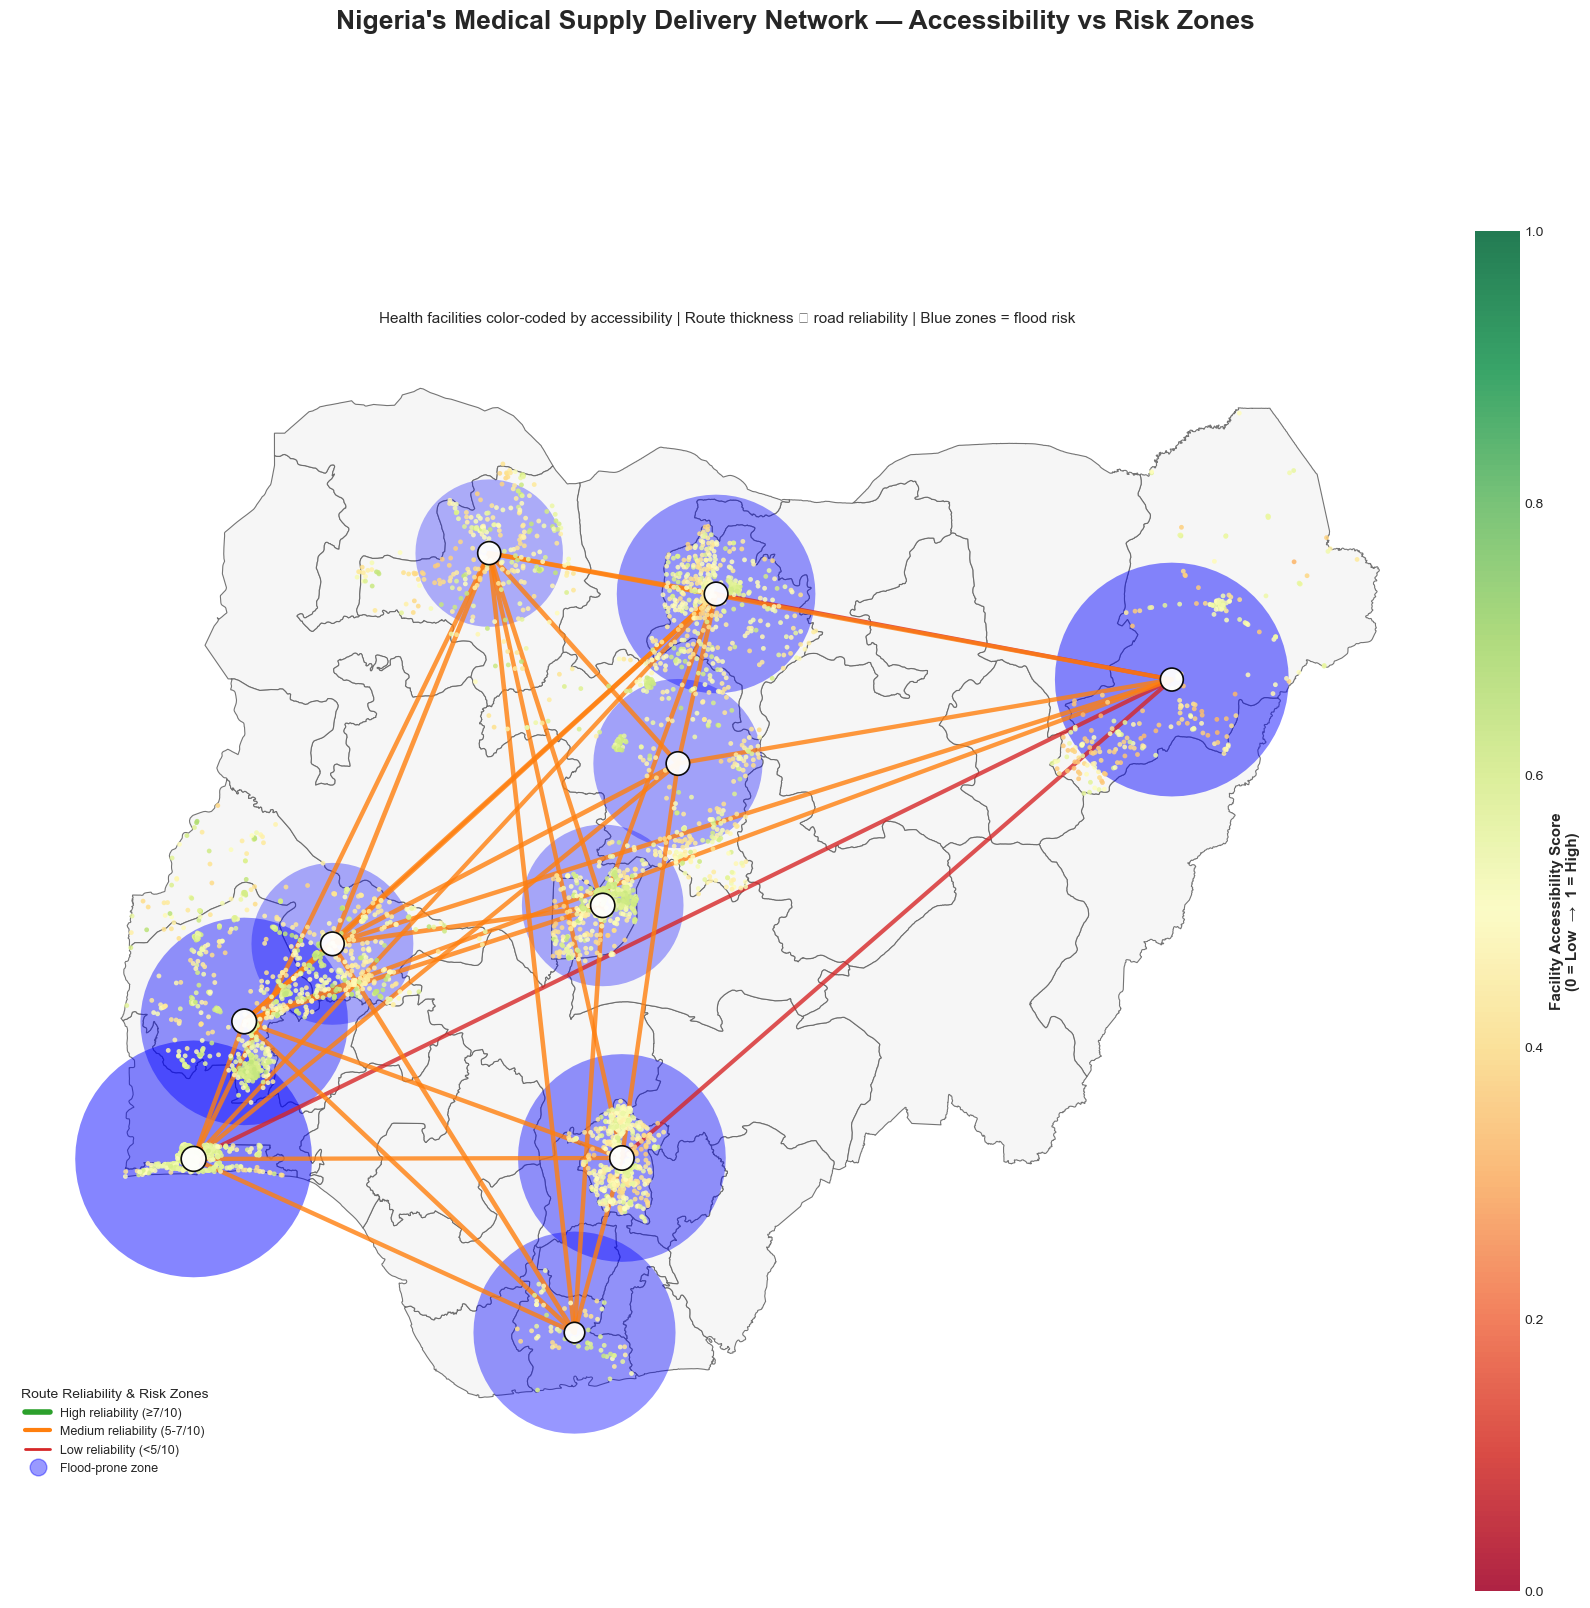

In [21]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os
import re

# Set random seed for reproducibility
np.random.seed(42)


GEOJSON_PATH = r"C:\Users\hp\Desktop\doub_PDF\nga_admin_boundaries.geojson\nga_admin1_em.geojson"
CSV_PATH = r"C:\Users\hp\Desktop\doub_PDF\medical_delivery_final.csv"
OUT_PNG = r"C:\Users\hp\Desktop\doub_PDF\nigeria_medical_supply_delivery_network.png"

TOP_N_STATES = 15

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def series_to_numeric(series, target_scale='1-10'):
    """Convert mixed numeric/categorical data to numeric scale"""
    s = series.astype(str).str.strip().replace({'nan':'', 'None':''})
    numeric = pd.to_numeric(
        s.str.replace('%','').str.extract(r'([-+]?\d*\.?\d+)', expand=False), 
        errors='coerce'
    )
    
    # Category mappings
    cat_map_1_10 = {
        'excellent': 9.0, 'very good': 8.5, 'verygood': 8.5, 'good': 7.0,
        'fair': 5.0, 'average': 5.0, 'moderate': 5.5, 'poor': 3.0,
        'bad': 2.0, 'very poor': 1.0
    }
    cat_map_0_1 = {
        'high': 0.9, 'medium': 0.5, 'moderate': 0.5, 'low': 0.1,
        'very high': 0.95, 'very low': 0.05
    }
    
    result = pd.Series(index=series.index, dtype=float)
    
    for idx, raw in s.items():
        val = numeric.loc[idx]
        if not pd.isna(val):
            raw_orig = str(series.loc[idx])
            if '%' in raw_orig:
                pct = float(val) / 100.0
                result.loc[idx] = pct * 10.0 if target_scale == '1-10' else pct
            else:
                if target_scale == '1-10':
                    result.loc[idx] = float(val) * 10.0 if val <= 1.1 else float(val)
                else:
                    result.loc[idx] = min(float(val) / 100.0, 1.0) if val > 1.1 else float(val)
        else:
            key = re.sub(r'[^a-z0-9 ]', '', raw.strip().lower())
            if target_scale == '1-10':
                result.loc[idx] = cat_map_1_10.get(key, np.nan)
            else:
                result.loc[idx] = cat_map_0_1.get(key, np.nan)
    
    return result

def estimate_distance(s1, s2):
    """Estimate distance between two states based on regional proximity"""
    regions = {
        'South-West': ['Lagos', 'Oyo', 'Ogun', 'Ondo', 'Osun', 'Ekiti'],
        'South-South': ['Rivers', 'Delta', 'Edo', 'Cross River', 'Akwa Ibom', 'Bayelsa'],
        'South-East': ['Anambra', 'Enugu', 'Abia', 'Imo', 'Ebonyi'],
        'North-Central': ['Abuja', 'FCT', 'Niger', 'Kogi', 'Kwara', 'Nasarawa', 'Plateau', 'Benue'],
        'North-West': ['Kano', 'Kaduna', 'Katsina', 'Sokoto', 'Zamfara', 'Kebbi', 'Jigawa'],
        'North-East': ['Borno', 'Yobe', 'Adamawa', 'Bauchi', 'Gombe', 'Taraba']
    }
    
    r1 = r2 = None
    for reg, stlist in regions.items():
        if s1 in stlist: r1 = reg
        if s2 in stlist: r2 = reg
    
    # Same region
    if r1 == r2 and r1 is not None:
        return float(np.random.uniform(80, 200))
    # Southern regions
    elif (r1 in ['South-West', 'South-South', 'South-East'] and 
          r2 in ['South-West', 'South-South', 'South-East']):
        return float(np.random.uniform(200, 400))
    # Northern regions
    elif (r1 in ['North-West', 'North-Central', 'North-East'] and 
          r2 in ['North-West', 'North-Central', 'North-East']):
        return float(np.random.uniform(200, 450))
    # Cross-regional
    else:
        return float(np.random.uniform(400, 800))

# =============================================================================
# LOAD DATA
# =============================================================================

print("=" * 70)
print("LOADING NIGERIA MEDICAL SUPPLY DELIVERY NETWORK DATA")
print("=" * 70)

# Load GeoJSON boundaries
print(f"\n1. Loading GeoJSON: {GEOJSON_PATH}")
nigeria_gdf = gpd.read_file(GEOJSON_PATH)
print(f"   ✓ Loaded {len(nigeria_gdf)} administrative regions")

# Load CSV data
print(f"\n2. Loading CSV: {CSV_PATH}")
df = pd.read_csv(CSV_PATH, encoding_errors='ignore')
print(f"   ✓ Loaded {df.shape[0]:,} records with {df.shape[1]} columns")

# =============================================================================
# DETECT AND CLEAN COLUMNS
# =============================================================================

print("\n3. Detecting key columns...")

# Detect state column
state_col = next((c for c in df.columns if 'state' in c.lower()), df.columns[0])

# Detect latitude/longitude columns
lat_col = next((c for c in df.columns if 'lat' in c.lower()), None)
lon_col = next((c for c in df.columns if 'lon' in c.lower() or 'long' in c.lower()), None)

if not lat_col:
    lat_col = next((c for c in df.columns if 'latitude' in c.lower()), None)
if not lon_col:
    lon_col = next((c for c in df.columns if 'longitude' in c.lower()), None)

if not lat_col or not lon_col:
    raise ValueError(f"Could not find lat/lon columns. Available: {df.columns.tolist()}")

print(f"   ✓ State: {state_col}")
print(f"   ✓ Latitude: {lat_col}")
print(f"   ✓ Longitude: {lon_col}")

# Clean geographic data
df[state_col] = df[state_col].astype(str).str.strip()
df[lat_col] = pd.to_numeric(df[lat_col], errors='coerce')
df[lon_col] = pd.to_numeric(df[lon_col], errors='coerce')
df = df.dropna(subset=[lat_col, lon_col]).reset_index(drop=True)
print(f"   ✓ Cleaned data: {len(df):,} facilities with valid coordinates")

# Detect road quality and flood risk columns
rq_col = next((c for c in df.columns if 'road' in c.lower() and 'quality' in c.lower()), None)
fr_col = next((c for c in df.columns if 'flood' in c.lower() and ('risk' in c.lower() or 'score' in c.lower())), None)

if rq_col:
    print(f"   ✓ Road Quality: {rq_col}")
if fr_col:
    print(f"   ✓ Flood Risk: {fr_col}")

# Convert to numeric
df['_rq_clean'] = series_to_numeric(df[rq_col], target_scale='1-10') if rq_col else np.nan
df['_fr_clean'] = series_to_numeric(df[fr_col], target_scale='0-1') if fr_col else np.nan

# =============================================================================
# STATE AGGREGATIONS
# =============================================================================

print("\n4. Calculating state-level metrics...")

# Count facilities per state
state_counts = df[state_col].value_counts().to_dict()
state_df = pd.DataFrame({
    'state': list(state_counts.keys()),
    'facility_count': list(state_counts.values())
})

# Average road quality per state
if '_rq_clean' in df.columns:
    avg_rq = (df.groupby(state_col)['_rq_clean']
              .mean()
              .rename('avg_road_quality')
              .reset_index()
              .rename(columns={state_col: 'state'}))
    state_df = state_df.merge(avg_rq, on='state', how='left')
else:
    state_df['avg_road_quality'] = np.nan

# Average flood risk per state
if '_fr_clean' in df.columns:
    avg_fr = (df.groupby(state_col)['_fr_clean']
              .mean()
              .rename('avg_flood_risk')
              .reset_index()
              .rename(columns={state_col: 'state'}))
    state_df = state_df.merge(avg_fr, on='state', how='left')
else:
    state_df['avg_flood_risk'] = np.nan

# Fill missing values with estimates
state_df['avg_road_quality'] = state_df['avg_road_quality'].fillna(
    state_df['facility_count'].apply(lambda c: min(8.0, 4.0 + c / 100.0))
)
state_df['avg_flood_risk'] = state_df['avg_flood_risk'].fillna(
    ((10 - state_df['avg_road_quality']) / 10.0)
).clip(0, 1)

# Normalize road quality to 1-10 scale if needed
if state_df['avg_road_quality'].max() <= 1.1:
    state_df['avg_road_quality'] *= 10.0

# Select top states for network visualization
top_states_df = state_df.sort_values('facility_count', ascending=False).head(TOP_N_STATES)
top_states = top_states_df['state'].tolist()
print(f"   ✓ Top {TOP_N_STATES} states: {', '.join(top_states[:5])}...")

# =============================================================================
# CALCULATE CENTROIDS AND ACCESSIBILITY
# =============================================================================

print("\n5. Computing state centroids and accessibility scores...")

# Calculate centroids for top states
centroids = (df[df[state_col].isin(top_states)]
             .groupby(state_col)
             .agg({lat_col: 'mean', lon_col: 'mean'})
             .reset_index()
             .rename(columns={
                 state_col: 'state',
                 lat_col: 'centroid_lat',
                 lon_col: 'centroid_lon'
             }))

centroids = centroids.merge(
    top_states_df[['state', 'avg_road_quality', 'avg_flood_risk', 'facility_count']],
    on='state', how='left'
)

# Calculate accessibility scores for facilities
rq_map = state_df.set_index('state')['avg_road_quality'].to_dict()
df['_state_avg_rq'] = df[state_col].map(rq_map).fillna(df['_rq_clean'].fillna(6.0))

# Handle distance if available
if 'Distance_km' in df.columns:
    df['Distance_km_clean'] = pd.to_numeric(df['Distance_km'], errors='coerce').fillna(
        df['Distance_km'].median()
    )
else:
    df['Distance_km_clean'] = np.nan

# Normalize road quality (0-1 scale)
rq_norm = (df['_state_avg_rq'] - 1.0) / 9.0

# Normalize distance inversely (closer = better)
if df['Distance_km_clean'].isna().all():
    dist_inv = pd.Series(0.5, index=df.index)
else:
    dist = df['Distance_km_clean'].fillna(df['Distance_km_clean'].median()).astype(float)
    dist_inv = 1.0 / (1.0 + (dist / dist.quantile(0.75)))
    dist_inv = (dist_inv - dist_inv.min()) / (dist_inv.max() - dist_inv.min() + 1e-9)

# Combined accessibility score (70% road quality, 30% distance)
df['accessibility_score'] = ((rq_norm * 0.7) + (dist_inv * 0.3)).clip(0, 1)
print(f"   ✓ Accessibility scores: min={df['accessibility_score'].min():.2f}, max={df['accessibility_score'].max():.2f}")

# =============================================================================
# CREATE DELIVERY ROUTE NETWORK
# =============================================================================

print("\n6. Building delivery route network...")

edges = []
for i, ri in centroids.iterrows():
    for j, rj in centroids.iterrows():
        if j <= i:
            continue
        
        dist = estimate_distance(ri['state'], rj['state'])
        
        # Only create routes under 600km
        if dist < 600:
            avg_rq = (ri['avg_road_quality'] + rj['avg_road_quality']) / 2.0
            edges.append({
                'from': ri['state'],
                'to': rj['state'],
                'from_xy': (ri['centroid_lon'], ri['centroid_lat']),
                'to_xy': (rj['centroid_lon'], rj['centroid_lat']),
                'distance_km': round(dist, 2),
                'road_quality': round(avg_rq, 2),
                'flood_risk': round((ri['avg_flood_risk'] + rj['avg_flood_risk']) / 2.0, 3)
            })

print(f"   ✓ Created {len(edges)} delivery routes")

# =============================================================================
# CREATE VISUALIZATION
# =============================================================================

print("\n7. Generating map visualization...")

fig, ax = plt.subplots(1, 1, figsize=(16, 18))

# Plot Nigeria state boundaries
nigeria_gdf.plot(ax=ax, facecolor='#f5f5f5', edgecolor='#666666', 
                linewidth=0.8, alpha=0.9, zorder=1)

# Plot flood risk zones (blue shaded circles)
for _, row in centroids.iterrows():
    fr = float(row['avg_flood_risk'])
    if fr > 0.01:
        # Radius scales with flood risk
        radius_m = 30000 + (fr * 120000)
        radius_deg = radius_m / 111000.0
        
        circ = Point(row['centroid_lon'], row['centroid_lat']).buffer(radius_deg)
        # Use geopandas to plot the circle
        gpd.GeoSeries([circ]).plot(ax=ax, facecolor='blue', edgecolor=None,
                                    alpha=0.12 + fr * 0.45, zorder=2)

# Draw delivery routes
for e in edges:
    x = [e['from_xy'][0], e['to_xy'][0]]
    y = [e['from_xy'][1], e['to_xy'][1]]
    rq = e['road_quality']
    
    # Line width proportional to road quality
    lw = 0.8 + (rq / 10.0) * 4.5
    
    # Color based on reliability
    if rq >= 7.0:
        color = '#2ca02c'  # Green - high reliability
    elif rq >= 5.0:
        color = '#ff7f0e'  # Orange - medium reliability
    else:
        color = '#d62728'  # Red - low reliability
    
    ax.plot(x, y, linewidth=lw, color=color, alpha=0.8, zorder=3)

# Plot state centroids (network hubs)
ax.scatter(centroids['centroid_lon'], centroids['centroid_lat'],
          s=50 + np.log1p(centroids['facility_count']) * 40,
          c='white', edgecolors='black', linewidths=1.2, 
          zorder=5, alpha=0.95)

# Plot health facilities (color-coded by accessibility)
sc = ax.scatter(df[lon_col], df[lat_col],
               s=12,
               c=df['accessibility_score'],
               cmap='RdYlGn',  # Red-Yellow-Green colormap
               vmin=0, vmax=1,
               alpha=0.85,
               edgecolors='none',
               zorder=4)

# Add colorbar
cb = fig.colorbar(sc, ax=ax, fraction=0.03, pad=0.02, aspect=30)
cb.set_label('Facility Accessibility Score\n(0 = Low  →  1 = High)', 
            fontsize=11, weight='bold')

# Create legend
import matplotlib.lines as mlines

high = mlines.Line2D([], [], color='#2ca02c', linewidth=4,
                    label='High reliability (≥7/10)')
mid = mlines.Line2D([], [], color='#ff7f0e', linewidth=3,
                   label='Medium reliability (5-7/10)')
low = mlines.Line2D([], [], color='#d62728', linewidth=2,
                   label='Low reliability (<5/10)')
flood = mlines.Line2D([], [], color='blue', linewidth=0, marker='o',
                     markersize=12, alpha=0.4, label='Flood-prone zone')

ax.legend(handles=[high, mid, low, flood], loc='lower left',
         title='Route Reliability & Risk Zones',
         fontsize=9, title_fontsize=10, framealpha=0.95)

# Add titles
plt.suptitle("Nigeria's Medical Supply Delivery Network — Accessibility vs Risk Zones",
            fontsize=19, fontweight='bold', y=0.96)
plt.title("Health facilities color-coded by accessibility | Route thickness ∝ road reliability | Blue zones = flood risk",
         fontsize=11, pad=10)

# Remove axes
ax.set_axis_off()

# Save figure
plt.tight_layout(rect=[0, 0, 1, 0.94])
os.makedirs(os.path.dirname(OUT_PNG), exist_ok=True)
plt.savefig(OUT_PNG, dpi=300, bbox_inches='tight', pad_inches=0.1, facecolor='white')

print(f"\n{'='*70}")
print(f"✓ SUCCESS! Map saved to:")
print(f"  {OUT_PNG}")
print(f"{'='*70}\n")

plt.show()

**DELIVERABLE FOUR: Exploratory Data Analysis (EDA)**

DATASET OVERVIEW

Dataset Shape: (4563, 9)

Column Names and Types:
State                object
LGA                  object
Facility_Name        object
Road_Quality         object
Distance_km         float64
Delivery_Time_hr    float64
Flood_Risk_Score    float64
Latitude            float64
Longitude           float64
dtype: object

First few rows:
   State         LGA                       Facility_Name Road_Quality  \
0  Borno      Damboa  Gumsuri Primary Health Care Center         Fair   
1  Borno  Askira/Uba           Uba Primary Health Center         Poor   
2  Borno  Askira/Uba  Ngulde Comprehensive Health Center         Fair   
3  Borno      Chibok     Shikarkir Primary Health Center         Poor   
4  Borno      Chibok                    Mifa Health Post         Poor   

   Distance_km  Delivery_Time_hr  Flood_Risk_Score   Latitude  Longitude  
0         9.49              0.74             57.43  11.059840  12.808550  
1         1.38              0.56             91.66  10.45899

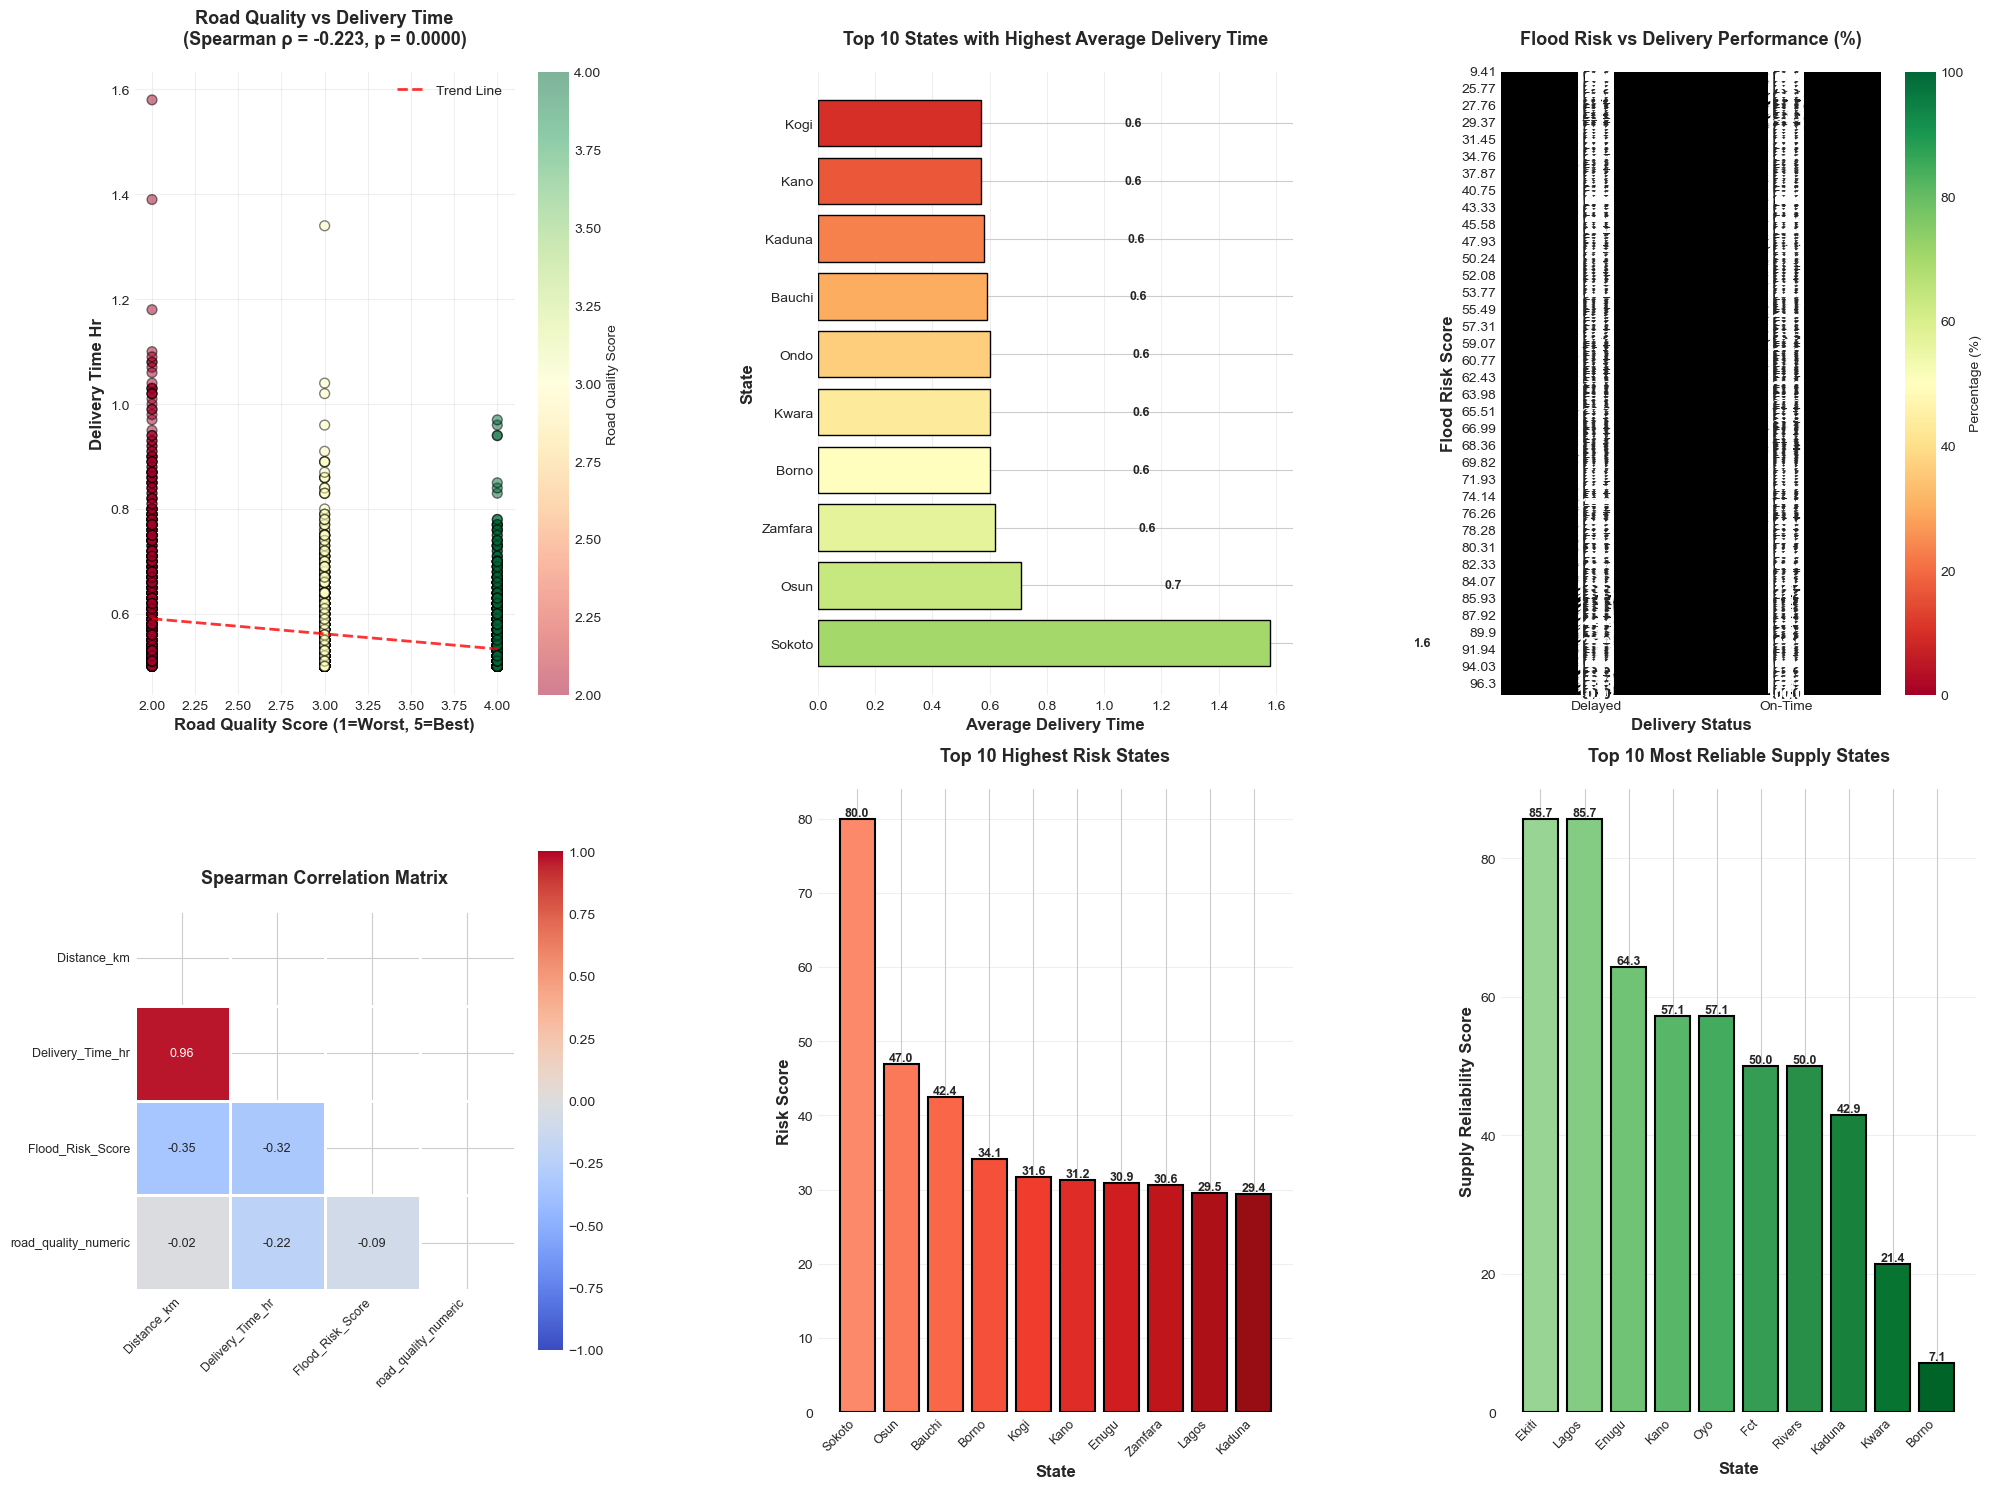


EXPORTING ANALYSIS RESULTS
✓ State metrics exported to 'state_risk_reliability_analysis.csv'
✓ Flood impact exported to 'flood_impact_by_region.csv'

KEY INSIGHTS SUMMARY

1. CORRELATION INSIGHTS:
   - Road quality and delivery time correlation: -0.2227
   - Correlation strength: Weak
   - Statistical significance: YES (p < 0.05)

2. RISK ASSESSMENT:
   - Highest risk state: Sokoto
     Risk Score: 80.00/100
     Avg Delivery Time: 1.58
     Avg Road Quality: 2.00/5

3. SUPPLY RELIABILITY:
   - Most reliable state: Ekiti
     Reliability Score: 85.71/100
   - Least reliable state: Ondo
     Reliability Score: 0.00/100

4. FLOOD IMPACT:
   - Average delivery time by flood risk level:
     9.41: 0.96 time units (1 deliveries)
     12.59: 0.83 time units (1 deliveries)
     12.71: 0.53 time units (1 deliveries)
     14.5: 0.52 time units (1 deliveries)
     14.93: 0.68 time units (1 deliveries)
     15.05: 0.62 time units (1 deliveries)
     16.72: 0.84 time units (1 deliveries)
     17.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Load the data
file_path = r'C:\Users\hp\medical_delivery_final.csv'
df = pd.read_csv(file_path)

# Display basic information
print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumn Names and Types:")
print(df.dtypes)
print(f"\nFirst few rows:")
print(df.head())
print(f"\nMissing Values:")
print(df.isnull().sum())

# ============================================================================
# DATA PREPROCESSING: Handle Categorical Road Quality
# ============================================================================
print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Identify columns
road_col = [col for col in df.columns if 'road' in col.lower()][0]
time_col = [col for col in df.columns if 'time' in col.lower() or 'delivery' in col.lower()][0]
state_col = [col for col in df.columns if 'state' in col.lower()][0]
flood_col = [col for col in df.columns if 'flood' in col.lower()][0]

print(f"\nIdentified Columns:")
print(f"  Road Quality: {road_col}")
print(f"  Delivery Time: {time_col}")
print(f"  State: {state_col}")
print(f"  Flood Risk: {flood_col}")

# Check if road quality is categorical
print(f"\nRoad Quality unique values: {df[road_col].unique()}")

# Convert categorical road quality to numeric scores
# Common mappings: Excellent=5, Good=4, Fair=3, Poor=2, Very Poor=1
road_quality_map = {
    'Excellent': 5,
    'Good': 4,
    'Fair': 3,
    'Poor': 2,
    'Very Poor': 1,
    'excellent': 5,
    'good': 4,
    'fair': 3,
    'poor': 2,
    'very poor': 1
}

# Create numeric version of road quality
df['road_quality_numeric'] = df[road_col].map(road_quality_map)

# If mapping didn't work (different categories), create a generic mapping
if df['road_quality_numeric'].isna().any():
    print("\nCreating generic mapping for road quality...")
    unique_values = sorted(df[road_col].unique())
    generic_map = {val: idx + 1 for idx, val in enumerate(unique_values)}
    df['road_quality_numeric'] = df[road_col].map(generic_map)
    print(f"Road Quality Mapping: {generic_map}")

print(f"\nNumeric Road Quality Statistics:")
print(df['road_quality_numeric'].describe())

# ============================================================================
# 1. SPEARMAN RANK CORRELATION: Road Quality vs Average Delivery Time
# ============================================================================
print("\n" + "="*70)
print("1. SPEARMAN RANK CORRELATION ANALYSIS")
print("="*70)

# Calculate Spearman correlation
corr_coefficient, p_value = spearmanr(df['road_quality_numeric'], df[time_col])

print(f"\nSpearman Rank Correlation Coefficient: {corr_coefficient:.4f}")
print(f"P-value: {p_value:.6f}")

if p_value < 0.05:
    print(f"Result: Statistically significant correlation (p < 0.05)")
else:
    print(f"Result: No statistically significant correlation (p >= 0.05)")

if corr_coefficient < 0:
    print(f"Interpretation: Better road quality (higher score) is associated with shorter delivery times")
elif corr_coefficient > 0:
    print(f"Interpretation: Better road quality (higher score) is associated with longer delivery times")

# ============================================================================
# 2. STATES WITH HIGHEST RISK AND LOWEST SUPPLY RELIABILITY
# ============================================================================
print("\n" + "="*70)
print("2. STATE-LEVEL RISK AND SUPPLY RELIABILITY ANALYSIS")
print("="*70)

# Calculate metrics by state
state_metrics = df.groupby(state_col).agg({
    time_col: ['mean', 'std', 'count'],
    'road_quality_numeric': 'mean'
}).round(2)

# Flatten column names
state_metrics.columns = ['avg_delivery_time', 'std_delivery_time', 'delivery_count', 'avg_road_quality']

# Add risk score (combination of high delivery time and poor road quality)
state_metrics['risk_score'] = (
    (state_metrics['avg_delivery_time'] / state_metrics['avg_delivery_time'].max()) * 0.6 +
    (1 - state_metrics['avg_road_quality'] / state_metrics['avg_road_quality'].max()) * 0.4
) * 100

# Calculate supply reliability (inverse of delivery time variance)
state_metrics['supply_reliability'] = (
    100 - (state_metrics['std_delivery_time'] / state_metrics['std_delivery_time'].max()) * 100
)

# Highest risk states
print("\nTOP 5 HIGHEST RISK STATES:")
print("-" * 70)
highest_risk = state_metrics.nlargest(5, 'risk_score')[['avg_delivery_time', 'avg_road_quality', 'risk_score']]
print(highest_risk)

# Lowest supply reliability states
print("\nTOP 5 LOWEST SUPPLY RELIABILITY STATES:")
print("-" * 70)
lowest_reliability = state_metrics.nsmallest(5, 'supply_reliability')[['avg_delivery_time', 'std_delivery_time', 'supply_reliability']]
print(lowest_reliability)

# ============================================================================
# 3. FLOOD IMPACT TRENDS ACROSS DELIVERY REGIONS
# ============================================================================
print("\n" + "="*70)
print("3. FLOOD IMPACT TRENDS ANALYSIS")
print("="*70)

# Identify region column (LGA or facility)
region_col = [col for col in df.columns if 'lga' in col.lower() or 'local' in col.lower() or 'facility' in col.lower() or 'region' in col.lower()]
region_col = region_col[0] if region_col else state_col

print(f"\nRegion Column: {region_col}")

# Flood impact by region
flood_impact = df.groupby([region_col, flood_col]).agg({
    time_col: 'mean',
    'road_quality_numeric': 'mean'
}).reset_index()
flood_impact.columns = [region_col, flood_col, 'avg_delivery_time', 'avg_road_quality']

print(f"\nFlood Impact by Region (First 10 rows):")
print(flood_impact.head(10))

# Overall flood impact
flood_summary = df.groupby(flood_col).agg({
    time_col: ['mean', 'count'],
    'road_quality_numeric': 'mean'
}).round(2)
flood_summary.columns = ['avg_delivery_time', 'delivery_count', 'avg_road_quality']
print(f"\nOverall Flood Impact on Delivery:")
print(flood_summary)

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Create figure with subplots
fig = plt.figure(figsize=(20, 15))

# 1. Road Quality vs Delivery Time (Scatter Plot)
ax1 = plt.subplot(2, 3, 1)
scatter = plt.scatter(df['road_quality_numeric'], df[time_col], alpha=0.5, 
                     c=df['road_quality_numeric'], cmap='RdYlGn', 
                     edgecolors='black', s=50)
plt.colorbar(scatter, label='Road Quality Score')
plt.xlabel('Road Quality Score (1=Worst, 5=Best)', fontsize=12, fontweight='bold')
plt.ylabel(time_col.replace('_', ' ').title(), fontsize=12, fontweight='bold')
plt.title(f'Road Quality vs Delivery Time\n(Spearman ρ = {corr_coefficient:.3f}, p = {p_value:.4f})', 
          fontsize=13, fontweight='bold', pad=20)
z = np.polyfit(df['road_quality_numeric'], df[time_col], 1)
p = np.poly1d(z)
plt.plot(sorted(df['road_quality_numeric'].unique()), 
         p(sorted(df['road_quality_numeric'].unique())), 
         "r--", alpha=0.8, linewidth=2, label='Trend Line')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Delivery Delays per State (Bar Chart)
ax2 = plt.subplot(2, 3, 2)
top_states = state_metrics.nlargest(10, 'avg_delivery_time')
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(top_states)))
bars = plt.barh(range(len(top_states)), top_states['avg_delivery_time'], color=colors, edgecolor='black')
plt.yticks(range(len(top_states)), top_states.index, fontsize=10)
plt.xlabel('Average Delivery Time', fontsize=12, fontweight='bold')
plt.ylabel('State', fontsize=12, fontweight='bold')
plt.title('Top 10 States with Highest Average Delivery Time', fontsize=13, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.1f}', 
             ha='left', va='center', fontsize=9, fontweight='bold')

# 3. Flood-Prone vs On-Time Deliveries (Heatmap)
ax3 = plt.subplot(2, 3, 3)
# Create delivery status based on median time
median_time = df[time_col].median()
df['delivery_status'] = df[time_col].apply(lambda x: 'On-Time' if x <= median_time else 'Delayed')

# Create pivot table for heatmap
heatmap_data = pd.crosstab(df[flood_col], df['delivery_status'], normalize='index') * 100
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', cbar_kws={'label': 'Percentage (%)'},
            linewidths=2, linecolor='black', vmin=0, vmax=100, annot_kws={'fontsize': 11, 'fontweight': 'bold'})
plt.xlabel('Delivery Status', fontsize=12, fontweight='bold')
plt.ylabel(flood_col.replace('_', ' ').title(), fontsize=12, fontweight='bold')
plt.title('Flood Risk vs Delivery Performance (%)', fontsize=13, fontweight='bold', pad=20)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# 4. Correlation Matrix (Road, Flood Risk, Distance, Time)
ax4 = plt.subplot(2, 3, 4)
# Select numeric columns for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Limit to relevant columns if too many
relevant_cols = [col for col in numeric_cols if any(keyword in col.lower() 
                 for keyword in ['time', 'distance', 'road', 'quality', 'flood', 'delay'])]
if len(relevant_cols) > 8:
    relevant_cols = relevant_cols[:8]
elif len(relevant_cols) < 3:
    relevant_cols = numeric_cols[:min(6, len(numeric_cols))]

corr_matrix = df[relevant_cols].corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1,
            annot_kws={'fontsize': 9})
plt.title('Spearman Correlation Matrix', fontsize=13, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

# 5. Risk Score by State (Top 10)
ax5 = plt.subplot(2, 3, 5)
top_risk = state_metrics.nlargest(10, 'risk_score')
colors_risk = plt.cm.Reds(np.linspace(0.4, 0.9, len(top_risk)))
bars_risk = plt.bar(range(len(top_risk)), top_risk['risk_score'], color=colors_risk, edgecolor='black', linewidth=1.5)
plt.xticks(range(len(top_risk)), top_risk.index, rotation=45, ha='right', fontsize=9)
plt.ylabel('Risk Score', fontsize=12, fontweight='bold')
plt.xlabel('State', fontsize=12, fontweight='bold')
plt.title('Top 10 Highest Risk States', fontsize=13, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars_risk:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 6. Supply Reliability by State (Top 10)
ax6 = plt.subplot(2, 3, 6)
top_reliability = state_metrics.nlargest(10, 'supply_reliability')
colors_rel = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_reliability)))
bars_rel = plt.bar(range(len(top_reliability)), top_reliability['supply_reliability'], 
                   color=colors_rel, edgecolor='black', linewidth=1.5)
plt.xticks(range(len(top_reliability)), top_reliability.index, rotation=45, ha='right', fontsize=9)
plt.ylabel('Supply Reliability Score', fontsize=12, fontweight='bold')
plt.xlabel('State', fontsize=12, fontweight='bold')
plt.title('Top 10 Most Reliable Supply States', fontsize=13, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars_rel:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('medical_delivery_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved as 'medical_delivery_comprehensive_analysis.png'")
plt.show()

# ============================================================================
# EXPORT ANALYSIS RESULTS
# ============================================================================
print("\n" + "="*70)
print("EXPORTING ANALYSIS RESULTS")
print("="*70)

# Export state metrics
state_metrics.to_csv('state_risk_reliability_analysis.csv')
print("✓ State metrics exported to 'state_risk_reliability_analysis.csv'")

# Export flood impact
flood_impact.to_csv('flood_impact_by_region.csv', index=False)
print("✓ Flood impact exported to 'flood_impact_by_region.csv'")

# ============================================================================
# KEY INSIGHTS SUMMARY
# ============================================================================
print("\n" + "="*70)
print("KEY INSIGHTS SUMMARY")
print("="*70)

print("\n1. CORRELATION INSIGHTS:")
print(f"   - Road quality and delivery time correlation: {corr_coefficient:.4f}")
if abs(corr_coefficient) > 0.7:
    strength = "Strong"
elif abs(corr_coefficient) > 0.4:
    strength = "Moderate"
else:
    strength = "Weak"
print(f"   - Correlation strength: {strength}")
print(f"   - Statistical significance: {'YES (p < 0.05)' if p_value < 0.05 else 'NO (p >= 0.05)'}")

print("\n2. RISK ASSESSMENT:")
print(f"   - Highest risk state: {state_metrics.nlargest(1, 'risk_score').index[0]}")
print(f"     Risk Score: {state_metrics['risk_score'].max():.2f}/100")
print(f"     Avg Delivery Time: {state_metrics.loc[state_metrics['risk_score'].idxmax(), 'avg_delivery_time']:.2f}")
print(f"     Avg Road Quality: {state_metrics.loc[state_metrics['risk_score'].idxmax(), 'avg_road_quality']:.2f}/5")

print("\n3. SUPPLY RELIABILITY:")
print(f"   - Most reliable state: {state_metrics.nlargest(1, 'supply_reliability').index[0]}")
print(f"     Reliability Score: {state_metrics['supply_reliability'].max():.2f}/100")
print(f"   - Least reliable state: {state_metrics.nsmallest(1, 'supply_reliability').index[0]}")
print(f"     Reliability Score: {state_metrics['supply_reliability'].min():.2f}/100")

print("\n4. FLOOD IMPACT:")
print(f"   - Average delivery time by flood risk level:")
for idx, row in flood_summary.iterrows():
    print(f"     {idx}: {row['avg_delivery_time']:.2f} time units ({row['delivery_count']:.0f} deliveries)")

print("\n5. DELIVERY PERFORMANCE:")
on_time_pct = (df['delivery_status'] == 'On-Time').sum() / len(df) * 100
print(f"   - Overall on-time delivery rate: {on_time_pct:.1f}%")
print(f"   - Median delivery time threshold: {median_time:.2f}")

print("\n" + "="*70)
print("ANALYSIS COMPLETE - All results saved!")
print("="*70)

**DELIVERABLE FIVE: Predictive & Cluster Analysis**

Loading: C:\Users\hp\medical_delivery_final.csv
Rows in file: 4563, Valid rows after cleaning: 4563
Results saved to C:\Users\hp\analysis_results.csv

Linear Regression metrics: {'r2': 0.8878462661991879, 'mae': 0.016547376529689697, 'rmse': np.float64(0.02957326421319322)}
Random Forest metrics: {'r2': 0.9984133194708761, 'mae': 0.00044173055859872255, 'rmse': np.float64(0.0035175245826412115)}


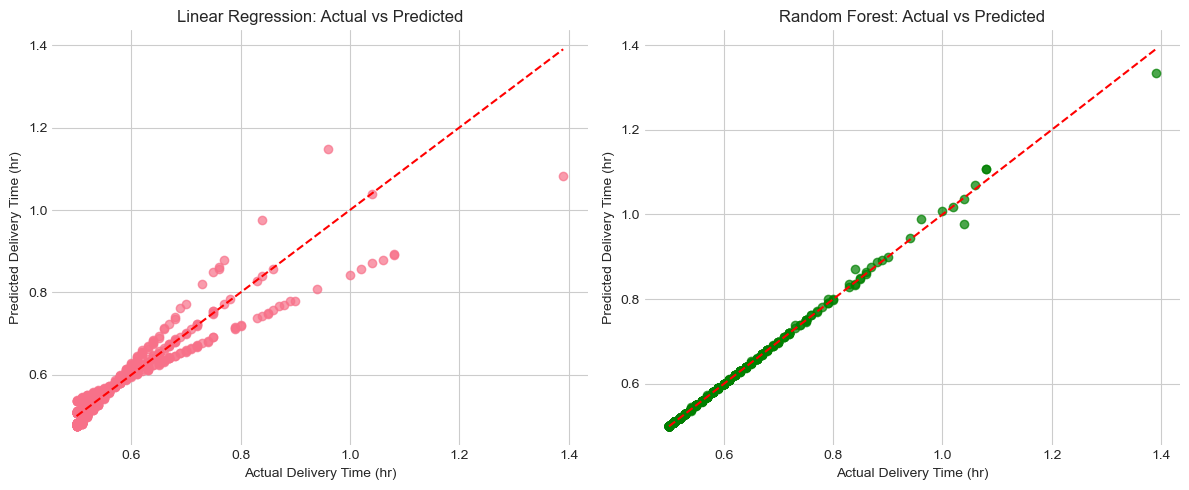

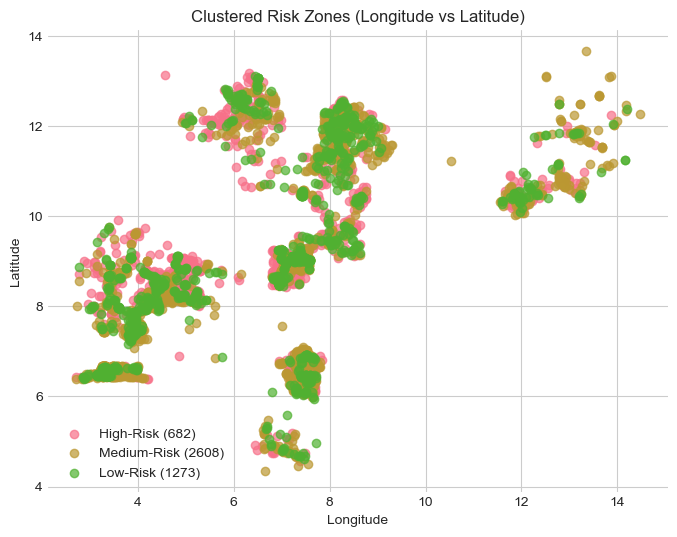


Summary:
 {'linear_regression_metrics': {'r2': 0.8878462661991879, 'mae': 0.016547376529689697, 'rmse': np.float64(0.02957326421319322)}, 'random_forest_metrics': {'r2': 0.9984133194708761, 'mae': 0.00044173055859872255, 'rmse': np.float64(0.0035175245826412115)}, 'n_total_rows': 4563, 'n_valid_rows': 4563, 'output_csv': 'C:\\Users\\hp\\analysis_results.csv'}


In [23]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

plt.rcParams.update({'figure.max_open_warning': 0})

CSV_PATH = r"C:\Users\hp\medical_delivery_final.csv"   # <-- your path

def normalize_headers(cols):
    def norm(c):
        return c.strip().replace('"','').replace("'", "").replace(" ", "_").lower()
    return [norm(c) for c in cols]

def load_and_clean(csv_path):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"{csv_path} not found in working directory ({os.getcwd()}).")
    # Let pandas infer delimiter; read as strings first for robust cleaning
    df = pd.read_csv(csv_path, dtype=str, keep_default_na=False, na_values=['', 'NA', 'NaN'])
    df.columns = normalize_headers(df.columns)
    
    mapping = {
        'distance_km': ['distance_km', 'distance', 'distance_km.', 'distance_km '],
        'delivery_time_hr': ['delivery_time_hr', 'delivery_time', 'delivery_time_hr.', 'delivery time'],
        'flood_risk_score': ['flood_risk_score', 'flood_risk', 'flood_risk_score.'],
        'road_quality': ['road_quality', 'road_quality_text', 'road_quality.'],
        'latitude': ['latitude','lat','y'],
        'longitude': ['longitude','lon','long','x'],
        'state': ['state'],
        'lga': ['lga'],
        'facility_name': ['facility_name','facility']
    }
    
    clean = pd.DataFrame()
    for std, candidates in mapping.items():
        for c in candidates:
            if c in df.columns:
                clean[std] = df[c].replace('', np.nan)
                break
        if std not in clean.columns:
            clean[std] = np.nan
    
    # numeric conversion
    for col in ['distance_km','delivery_time_hr','flood_risk_score','latitude','longitude']:
        clean[col] = pd.to_numeric(clean[col], errors='coerce')
    
    # road quality to numeric (1-5)
    def road_to_num(x):
        if pd.isna(x): return np.nan
        s = str(x).strip().lower()
        if s in ('5','4','3','2','1'):
            try: return float(s)
            except: pass
        if 'excellent' in s or 'very good' in s: return 5.0
        if 'good' in s: return 4.0
        if 'fair' in s or 'moderate' in s: return 3.0
        if 'poor' in s: return 2.0
        if 'very poor' in s or 'bad' in s: return 1.0
        try: return float(s)
        except: return np.nan
    clean['road_quality'] = clean['road_quality'].apply(road_to_num)
    
    # keep original id columns if present in the raw df
    for col in ['state','lga','facility_name']:
        if col in df.columns and col not in clean.columns:
            clean[col] = df[col]
    
    valid = clean.dropna(subset=['distance_km','delivery_time_hr','flood_risk_score','road_quality'])
    valid = valid[(valid['distance_km'] > 0) & (valid['delivery_time_hr'] > 0)]
    valid = valid.reset_index(drop=True)
    return valid, clean

def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {'r2': r2, 'mae': mae, 'rmse': rmse}

def run_full_analysis(csv_path=CSV_PATH, random_state=42, out_dir=None):
    if out_dir is None:
        out_dir = os.path.dirname(csv_path) or os.getcwd()
    print("Loading:", csv_path)
    df_valid, df_all = load_and_clean(csv_path)
    n_total = len(df_all)
    n_valid = len(df_valid)
    print(f"Rows in file: {n_total}, Valid rows after cleaning: {n_valid}")
    if n_valid < 10:
        raise ValueError("Not enough valid rows to run the analysis (need >=10).")
    
    X = df_valid[['distance_km','flood_risk_score','road_quality']].values
    y = df_valid['delivery_time_hr'].values.astype(float)
    
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, df_valid.index, test_size=0.2, random_state=random_state)
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)
    lr_metrics = compute_metrics(y_test, lr_pred)
    
    rf = RandomForestRegressor(n_estimators=100, random_state=random_state)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_metrics = compute_metrics(y_test, rf_pred)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans = KMeans(n_clusters=3, random_state=random_state, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    centroids = kmeans.cluster_centers_
    
    centroid_scores = []
    for c in centroids:
        dist, flood, road = c
        score = dist * 0.4 + flood * 0.5 - road * 0.1
        centroid_scores.append(score)
    ordering = np.argsort(centroid_scores)[::-1]
    label_map = {ordering[0]:'High-Risk', ordering[1]:'Medium-Risk', ordering[2]:'Low-Risk'}
    risk_labels = [label_map[c] for c in clusters]
    
    results_df = df_valid.copy()
    results_df['cluster'] = clusters
    results_df['risk_label'] = risk_labels
    results_df['lr_pred'] = np.nan
    results_df['rf_pred'] = np.nan
    results_df.loc[idx_test, 'lr_pred'] = lr_pred
    results_df.loc[idx_test, 'rf_pred'] = rf_pred
    
    out_csv = os.path.join(out_dir, 'analysis_results.csv')
    results_df.to_csv(out_csv, index=False)
    print(f"Results saved to {out_csv}")
    
    print("\nLinear Regression metrics:", lr_metrics)
    print("Random Forest metrics:", rf_metrics)
    
    # Plots: Actual vs Predicted
    fig, axes = plt.subplots(1,2, figsize=(12,5))
    axes[0].scatter(y_test, lr_pred, alpha=0.7)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[0].set_title('Linear Regression: Actual vs Predicted')
    axes[0].set_xlabel('Actual Delivery Time (hr)')
    axes[0].set_ylabel('Predicted Delivery Time (hr)')
    
    axes[1].scatter(y_test, rf_pred, alpha=0.7, color='green')
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[1].set_title('Random Forest: Actual vs Predicted')
    axes[1].set_xlabel('Actual Delivery Time (hr)')
    axes[1].set_ylabel('Predicted Delivery Time (hr)')
    plt.tight_layout()
    plt.show()
    
    # Cluster scatter on lat/lon if available
    if 'latitude' in results_df.columns and 'longitude' in results_df.columns:
        if results_df['latitude'].notna().any() and results_df['longitude'].notna().any():
            plt.figure(figsize=(8,6))
            for label, color in zip(['High-Risk','Medium-Risk','Low-Risk'], ['red','orange','green']):
                subset = results_df[results_df['risk_label']==label]
                plt.scatter(subset['longitude'], subset['latitude'], label=f"{label} ({len(subset)})", alpha=0.7)
            plt.legend()
            plt.title('Clustered Risk Zones (Longitude vs Latitude)')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.show()
    
    summary = {
        'linear_regression_metrics': lr_metrics,
        'random_forest_metrics': rf_metrics,
        'n_total_rows': n_total,
        'n_valid_rows': n_valid,
        'output_csv': out_csv
    }
    return summary, results_df, lr, rf, kmeans

# Run it
summary, results_df, lr_model, rf_model, kmeans_model = run_full_analysis(CSV_PATH)
print("\nSummary:\n", summary)
